In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In order to run all of the code from the start, change the drive path below to your own path where the train set and test set resides. 

In [3]:
cd "/content/drive/My Drive/Colab Notebooks/Stock_Price_Forecasting"

/content/drive/My Drive/Colab Notebooks/Stock_Price_Forecasting


### Task 1: Data Preparation 

In [1]:
import pandas as pd
import numpy as np
import pickle

# Load the training dataset
with open("training_set.pkl", "rb") as f:
    train_data = pickle.load(f)

In [2]:
# Function to calculate daily percentage changes for given dataframes
def calculate_daily_percentage_changes(dataframes):
    percentage_changes = []
    for df in dataframes:
        # Extract the Close prices
        close_prices = df["Close"]
        # Calculate daily percentage changes and remove NaN values
        daily_changes = close_prices.pct_change().dropna()
        percentage_changes.extend(daily_changes)
    return percentage_changes

# Function to divide percentage changes into 3 levels
def divide_changes_into_levels(percentage_changes):
    sorted_changes = sorted(percentage_changes)
    total_data_points = len(sorted_changes)
    # Calculate the thresholds to divide the data into 3 levels
    threshold1 = sorted_changes[total_data_points // 3]
    threshold2 = sorted_changes[2 * total_data_points // 3]

    # Count the number of data points in each level
    level1_count = sum(1 for change in percentage_changes if change <= threshold1)
    level2_count = sum(1 for change in percentage_changes if threshold1 < change <= threshold2)
    level3_count = sum(1 for change in percentage_changes if change > threshold2)

    return threshold1, threshold2, level1_count, level2_count, level3_count

percentage_changes = calculate_daily_percentage_changes(train_data)
threshold1, threshold2, level1_count, level2_count, level3_count = divide_changes_into_levels(percentage_changes)

print(f"Threshold 1: {threshold1}")
print(f"Threshold 2: {threshold2}")
print(f"Number of data points in Level 1 (decrease): {level1_count}")
print(f"Number of data points in Level 2 (no big change): {level2_count}")
print(f"Number of data points in Level 3 (increase): {level3_count}")


Threshold 1: -0.0021083380450702682
Threshold 2: 0.0019827979341888735
Number of data points in Level 1 (decrease): 1467334
Number of data points in Level 2 (no big change): 1467336
Number of data points in Level 3 (increase): 1467330


### Task 2: Feature Engineering 

In [3]:
train_df = pd.concat(train_data, axis=0, ignore_index=True)

In [4]:
!pip install pandas_ta
import pandas_ta as ta


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: c:\users\eged1\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


In [5]:
def generate_new_features(df):
    # Normalize and scale features
    df["Current_Open/Range_Open"] = df["Open"] / (df["Open"].max() - df["Open"].min())
    df["Current_High/Range_High"] = df["High"] / (df["High"].max() - df["High"].min())
    df["Current_Low/Range_Low"] = df["Low"] / (df["Low"].max() - df["Low"].min())
    df["Current_Close/Range_Close"] = df["Close"] / (df["Close"].max() - df["Close"].min())
    df["Current_Volume/Range_Volume"] = df["Volume"] / (df["Volume"].max() - df["Volume"].min())

    # Normalize by standard deviation
    df["Current_Open/std"] = df["Open"]/df["Open"].std()
    df["Current_High/std"] = df["High"]/df["High"].std()
    df["Current_Low/std"] = df["Low"]/df["Low"].std()
    df["Current_Close/std"] = df["Close"]/df["Close"].std()

    # Calculate difference from mean
    df["Current_Open - Mean_Open"] = df["Open"] - df["Open"].mean()
    df["Current_High - Mean_High"] = df["High"] - df["High"].mean()
    df["Current_Low - Mean_Low"] = df["Low"] - df["Low"].mean()
    df["Current_Close - Mean_Close"] = df["Close"] - df["Close"].mean()

    # Calculate interaction features
    df["Open*Volume"] = df["Open"] * df["Volume"]
    df["High*Volume"] = df["High"] * df["Volume"]
    df["Low*Volume"] = df["Low"] * df["Volume"]
    df["Close*Volume"] = df["Close"] * df["Volume"]

    # Calculate price differences
    df["High - Low"] = df["High"] - df["Low"]   
    df["Close - Open"] = df["Close"] - df["Open"]    

    # Calculate other price differences
    df["High - Close"] = df["High"] - df["Close"]
    df["High - Open"] = df["High"] - df["Open"]
    df["Low - Close"] = df["Low"] - df["Close"]
    df["Low - Open"] = df["Low"] - df["Open"]

    # Calculate interaction features with volume
    df["(High - Low)*Volume"] = df["High - Low"] * df["Volume"]
    df["(Close - Open)*Volume"] = df["Close - Open"] * df["Volume"]
    df["(High - Close)*Volume"] = df["High - Close"] * df["Volume"]
    df["(High - Open)*Volume"] = df["High - Open"] * df["Volume"]
    df["(Low - Close)*Volume"] = df["Low - Close"] * df["Volume"]
    df["(Low - Open)*Volume"] = df["Low - Open"] * df["Volume"]

    # Calculate cumulative normalized sum features
    df["Cumulative_Normalized_Sum_Open"] = df["Open"].cumsum() / (df["Open"].index + 1)
    df["Cumulative_Normalized_Sum_High"] = df["High"].cumsum() / (df["High"].index + 1)
    df["Cumulative_Normalized_Sum_Low"] = df["Low"].cumsum() / (df["Low"].index + 1)
    df["Cumulative_Normalized_Sum_Close"] = df["Close"].cumsum() / (df["Close"].index + 1)
    df["Cumulative_Normalized_Sum_Volume"] = df["Volume"].cumsum() / (df["Volume"].index + 1)

    # Calculate additional features based on existing ones
    cols = list((df).columns)[19:]

    for col in cols:
        df[col + " - Mean"] = df[col]-df[col].mean()
        df[col + "/std"] = df[col] / df[col].std()
        df[col + "/Range"] = df[col] / (df[col].max() - df[col].min())
    
    # Calculate rolling standard deviations
    df["Std_5"] = df["Close"].rolling(window=5).std()
    df["Std_10"] = df["Close"].rolling(window=10).std()
    df["Std_20"] = df["Close"].rolling(window=20).std()

    # Moving averages
    df["MA_5"] = df["Close"].rolling(window=5).mean()
    df["MA_10"] = df["Close"].rolling(window=10).mean()
    df["MA_20"] = df["Close"].rolling(window=20).mean()

    # Calculate MACD (Moving Average Convergence Divergence)
    macd = ta.macd(df["Close"])
    df["MACD"] = macd.iloc[:, 0]
    df["MACD_Hist"] = macd.iloc[:, 1]
    df["MACD_Signal"] = macd.iloc[:, 2]
    
    # Calculate RSI (Relative Strength Index)
    df["RSI"] = ta.rsi(df["Close"])

    # Calculate MFI (Money Flow Index)
    df["MFI"] = ta.mfi(df["High"], df["Low"], df["Close"], df["Volume"])

In [6]:
generate_new_features(train_df)

<ipython-input-5-1f8b4d79c794>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_10"] = df["Close"].rolling(window=10).mean()
<ipython-input-5-1f8b4d79c794>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_20"] = df["Close"].rolling(window=20).mean()
<ipython-input-5-1f8b4d79c794>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

In [7]:
def add_label(df):
    df["Label"] = 1
    df.loc[df["Close"].pct_change() <= threshold1, "Label"] = 0
    df.loc[df["Close"].pct_change() > threshold2, "Label"] = 2

add_label(train_df)

<ipython-input-7-c8ecc8c37635>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Label"] = 1


In [8]:
# Print the last 5 data points for the first stock
end = len(train_data[0]) 
start = len(train_data[0]) - 5 
print(train_df[start:end])

          Open      High       Low     Close    Volume  \
2197  0.680849  0.683633  0.672997  0.674055  0.351048   
2198  0.674389  0.674890  0.671326  0.674055  0.143069   
2199  0.674110  0.676227  0.672440  0.676004  0.312048   
2200  0.675725  0.675837  0.668820  0.669321  0.279230   
2201  0.669293  0.671326  0.662973  0.664198  0.552933   

      Current_Open/Range_Open  Current_High/Range_High  Current_Low/Range_Low  \
2197                 0.684178                 0.687009               0.676338   
2198                 0.677687                 0.678223               0.674659   
2199                 0.677407                 0.679566               0.675778   
2200                 0.679030                 0.679174               0.672140   
2201                 0.672566                 0.674641               0.666264   

      Current_Close/Range_Close  Current_Volume/Range_Volume  ...    Std_20  \
2197                   0.677344                     0.175524  ...  0.008223   
2198  

### Task 3: Training Predictive Models

In [21]:
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

!pip install catboost
from catboost import CatBoostClassifier


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: c:\users\eged1\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


It's not feasible to train with the whole dataset.
So, we sample from the whole set with randomness.
But we can't just random_sample because our data points 
  are only meaningfull with their predecessors.
So we randomly sample back to back rows with size = 50.

In [ ]:
def sample_from_all(df, sample_size):
    # Define a list of possible index increments
    increase_index_by = [10,50,100,200,500,1000,5000] # skip through data with random amount
    
    # Initialize the result dataframe with the first 50 rows of the input dataframe
    result_df = df[49:100]
    
    # Randomly choose an index increment
    i = random.choice(increase_index_by)
    while(i<len(df)-51 and len(result_df) < sample_size):
        temp_df = df[i:i+50]
        # Concatenate the extracted rows to the result dataframe
        result_df = pd.concat([temp_df, result_df], axis=0, ignore_index=True)
        # Increment the index using another random value from the list
        i += random.choice(increase_index_by)
    
    # Return the result dataframe containing the sampled rows
    return result_df

In [ ]:
sample_size = 2*10**4
sample = sample_from_all(train_df, sample_size)
len(sample)

20001

In [ ]:
# extract labels
X = sample.drop(["Label"], axis=1)
y = list(sample["Label"])

In [ ]:
# Split the dataset into a primary training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define 9 models
models = [
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='linear', C=1),
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(),
    ExtraTreesClassifier(n_estimators=100),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0, loss_function='MultiClass')
]

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


#### Train Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define the custom dataset class
class StockDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__(self):
        return len(self.X_data)

# Define the neural network model
class StockModel(nn.Module):
    def __init__(self, num_features):
        super(StockModel, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 3)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

# Prepare the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_torch = scaler.fit_transform(X_train)
X_val_torch = scaler.transform(X_val)

# Convert the data to PyTorch tensors
X_train_torch = torch.tensor(X_train_torch, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_val_torch = torch.tensor(X_val_torch, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader objects
train_dataset = StockDataset(X_train_torch, y_train_torch)
val_dataset = StockDataset(X_val_torch, y_val_torch)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = StockModel(X_train_torch.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
    
    if(epoch % 10 == 9):
        #print(epoch)
        print(f"Epoch = {epoch+1}       Loss = {loss.item()}")

    # Evaluate the model
    model.eval()
    y_pred_train = model(X_train_torch.to(device)).detach().cpu()
    y_pred_val = model(X_val_torch.to(device)).detach().cpu()

Epoch = 10       Loss = 0.35135596990585327
Epoch = 20       Loss = 0.40821483731269836
Epoch = 30       Loss = 0.3072258234024048
Epoch = 40       Loss = 0.3752862215042114
Epoch = 50       Loss = 0.20226754248142242


#### Print evaluation scores of all 10 models

In [ ]:
!cd models/

In [ ]:
#Print Neural Network evaluation score
for dataset_name, X_data, y_data, y_pred in [("Train", X_train_torch, y_train_torch, y_pred_train), ("Validation", X_val_torch, y_val_torch, y_pred_val)]:
    accuracy = accuracy_score(y_data, torch.argmax(y_pred, dim=1))
    precision = float(precision_score(y_data, torch.argmax(y_pred, dim=1), average=None)[2])
    pos_predictions_percentage = torch.sum(torch.argmax(y_pred, dim=1) == 2) / len(y_pred)

    print(f"Neural Network on {dataset_name} Set:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision}")
    print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
    print()



#Train, save, and evaluate the ML models we defined before
import os
from joblib import dump

# Create a directory to save the models
os.makedirs("models", exist_ok=True)

for model in models:
    model.fit(X_train, y_train)

    # Save the trained model
    model_filename = f"models/{model.__class__.__name__}_model.joblib"
    dump(model, model_filename)

    # Evaluate the model
    for dataset_name, X_data, y_data in [("Train", X_train, y_train), ("Validation", X_val, y_val)]:
        y_pred = model.predict(X_data)

        accuracy = accuracy_score(y_data, y_pred)
        precision = float(precision_score(y_data, y_pred, average=None)[2])
        pos_predictions_percentage = np.sum(y_pred == 2) / len(y_pred)

        print(f"{model.__class__.__name__} on {dataset_name} Set:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision: {precision}")
        print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
        print()

Neural Network on Train Set:
  - Accuracy: 0.8960
  - Precision: 0.9252558479532164
  - Percentage of positive predictions: 0.3420

Neural Network on Validation Set:
  - Accuracy: 0.8755
  - Precision: 0.912472647702407
  - Percentage of positive predictions: 0.3427

RandomForestClassifier on Train Set:
  - Accuracy: 1.0000
  - Precision: 1.0
  - Percentage of positive predictions: 0.3470

RandomForestClassifier on Validation Set:
  - Accuracy: 0.8978
  - Precision: 0.9250909090909091
  - Percentage of positive predictions: 0.3437

SVC on Train Set:
  - Accuracy: 0.8669
  - Precision: 0.8996859412525402
  - Percentage of positive predictions: 0.3383

SVC on Validation Set:
  - Accuracy: 0.8663
  - Precision: 0.9003636363636364
  - Percentage of positive predictions: 0.3437

LogisticRegression on Train Set:
  - Accuracy: 0.8297
  - Precision: 0.8569146103319724
  - Percentage of positive predictions: 0.3521

LogisticRegression on Validation Set:
  - Accuracy: 0.8323
  - Precision: 0.864

### Task 4: Feature Selection 

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [ ]:
X_selected = SelectPercentile(score_func=f_classif, percentile=30).fit_transform(X, y)

In [ ]:
X_selected.shape

(20001, 33)

In [ ]:
X_train_selected, X_val_selected, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
# Prepare the data
scaler = StandardScaler()
X_train_torch_selected = scaler.fit_transform(X_train_selected)
X_val_torch_selected = scaler.transform(X_val_selected)

# Convert the data to PyTorch tensors
X_train_torch_selected = torch.tensor(X_train_torch_selected, dtype=torch.float32)
y_train_torch_selected = torch.tensor(y_train, dtype=torch.long)
X_val_torch_selected = torch.tensor(X_val_torch_selected, dtype=torch.float32)
y_val_torch_selected = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader objects
train_dataset_selected = StockDataset(X_train_torch_selected, y_train_torch_selected)
val_dataset_selected = StockDataset(X_val_torch_selected, y_val_torch_selected)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset_selected, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset_selected, batch_size=1)

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_selected = StockModel(X_train_torch_selected.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_selected.parameters(), lr=0.001)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model_selected.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred_selected = model_selected(X_batch)
        loss = criterion(y_pred_selected, y_batch)

        loss.backward()
        optimizer.step()
    
    if(epoch % 10 == 9):
        #print(epoch)
        print(f"Epoch = {epoch+1}       Loss = {loss.item()}")

    # Evaluate the model
    model_selected.eval()
    y_pred_train_selected = model_selected(X_train_torch_selected.to(device)).detach().cpu()
    y_pred_val_selected = model_selected(X_val_torch_selected.to(device)).detach().cpu()

Epoch = 10       Loss = 0.3236437439918518
Epoch = 20       Loss = 0.24292291700839996
Epoch = 30       Loss = 0.5100598931312561
Epoch = 40       Loss = 0.3567679524421692
Epoch = 50       Loss = 0.4264383316040039


In [ ]:
#Print Neural Network evaluation score
for dataset_name, X_data, y_data, y_pred in [("Train", X_train_torch_selected, y_train_torch_selected, y_pred_train_selected), ("Validation", X_val_torch_selected, y_val_torch_selected, y_pred_val_selected)]:
    accuracy = accuracy_score(y_data, torch.argmax(y_pred, dim=1))
    precision = float(precision_score(y_data, torch.argmax(y_pred, dim=1), average=None)[2])
    pos_predictions_percentage = torch.sum(torch.argmax(y_pred, dim=1) == 2) / len(y_pred)

    print(f"Neural Network on {dataset_name} Set:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision}")
    print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
    print()

    
for model in models:
    model.fit(X_train_selected, y_train)

    # Evaluate the model
    for dataset_name, X_data, y_data in [("Train", X_train_selected, y_train), ("Validation", X_val_selected, y_val)]:
        y_pred_selected = model.predict(X_data)

        accuracy = accuracy_score(y_data, y_pred_selected)
        precision = float(precision_score(y_data, y_pred_selected, average=None)[2])
        pos_predictions_percentage = np.sum(y_pred_selected == 2) / len(y_pred_selected)

        print(f"{model.__class__.__name__} on {dataset_name} Set:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision: {precision}")
        print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
        print()

Neural Network on Train Set:
  - Accuracy: 0.8884
  - Precision: 0.9137900513365197
  - Percentage of positive predictions: 0.3531

Neural Network on Validation Set:
  - Accuracy: 0.8833
  - Precision: 0.9073305670816044
  - Percentage of positive predictions: 0.3614

RandomForestClassifier on Train Set:
  - Accuracy: 0.9999
  - Precision: 1.0
  - Percentage of positive predictions: 0.3537

RandomForestClassifier on Validation Set:
  - Accuracy: 0.9025
  - Precision: 0.9230230930720784
  - Percentage of positive predictions: 0.3572

SVC on Train Set:
  - Accuracy: 0.8696
  - Precision: 0.9028077753779697
  - Percentage of positive predictions: 0.3473

SVC on Validation Set:
  - Accuracy: 0.8683
  - Precision: 0.8989399293286219
  - Percentage of positive predictions: 0.3537

LogisticRegression on Train Set:
  - Accuracy: 0.8351
  - Precision: 0.8564838544336237
  - Percentage of positive predictions: 0.3658

LogisticRegression on Validation Set:
  - Accuracy: 0.8340
  - Precision: 0.85

After experimenting with various feature selection methods with different feature numbers, we acquired worse results than before, for all classifiers. We will not use it for the final model.

### Task 5: Model Ensembling (voting & blending) and Adaboosting 

In [ ]:
from joblib import load

saved_model_paths = [
"models/CatBoostClassifier_model.joblib",
"models/DecisionTreeClassifier_model.joblib",
"models/GradientBoostingClassifier_model.joblib",
"models/LGBMClassifier_model.joblib",
"models/LogisticRegression_model.joblib",
"models/RandomForestClassifier_model.joblib",
"models/XGBClassifier_model.joblib"
]

loaded_models = [load(model_path) for model_path in saved_model_paths]

In [ ]:
### ADABOOST
from sklearn.ensemble import AdaBoostClassifier

models = [
    AdaBoostClassifier(),
]

for model in models:
    model.fit(X_train, y_train)

    # Save the trained model
    model_filename = f"models/{model.__class__.__name__}.joblib"
    dump(model, model_filename)

    # Evaluate the model
    for dataset_name, X_data, y_data in [("Train", X_train, y_train), ("Validation", X_val, y_val)]:
        y_pred = model.predict(X_data)

        accuracy = accuracy_score(y_data, y_pred)
        precision = float(precision_score(y_data, y_pred, average=None)[2])
        pos_predictions_percentage = np.sum(y_pred == 2) / len(y_pred)

        print(f"{model.__class__.__name__} on {dataset_name} Set:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision: {precision}")
        print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
        print()


AdaBoostClassifier on Train Set:
  - Accuracy: 0.8674
  - Precision: 0.8892366544948704
  - Percentage of positive predictions: 0.3594

AdaBoostClassifier on Validation Set:
  - Accuracy: 0.8600
  - Precision: 0.879837067209776
  - Percentage of positive predictions: 0.3682



In [ ]:
from sklearn.ensemble import VotingClassifier

voting_ensemble = VotingClassifier(estimators=[(f'model_{i}', model) for i, model in enumerate(loaded_models)], voting='soft')
voting_ensemble.fit(X_train, y_train)

y_pred_train = voting_ensemble.predict(X_train)
y_pred_val = voting_ensemble.predict(X_val)

# Calculate accuracy, precision, and positive predictions percentage for both train and validation sets
for dataset_name, X_data, y_data, y_pred in zip(['Train', 'Validation'], [X_train, X_val], [y_train, y_val], [y_pred_train, y_pred_val]):
    accuracy = accuracy_score(y_data, y_pred)
    precision = float(precision_score(y_data, y_pred, average=None)[2])
    pos_predictions_percentage = np.sum(y_pred == 2) / len(y_pred)

    print(f"Voting Ensemble on {dataset_name} Set:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
    print()

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Voting Ensemble on Train Set:
  - Accuracy: 0.9866
  - Precision: 0.9858
  - Percentage of positive predictions: 0.3556

Voting Ensemble on Validation Set:
  - Accuracy: 0.9003
  - Precision: 0.9186
  - Percentage of positive predictions: 0.3594



In [ ]:
train_predictions = np.column_stack([model.predict(X_train) for model in models])
val_predictions = np.column_stack([model.predict(X_val) for model in models])

In [ ]:
train_blended = np.array([np.bincount(pred).argmax() for pred in train_predictions])
val_blended = np.array([np.bincount(pred).argmax() for pred in val_predictions])

In [ ]:
for dataset_name, y_data, y_pred in zip(['Train', 'Validation'], [y_train, y_val], [train_blended, val_blended]):
    accuracy = accuracy_score(y_data, y_pred)
    precision = float(precision_score(y_data, y_pred, average=None)[2])
    pos_predictions_percentage = np.sum(y_pred == 2) / len(y_pred)

    print(f"Blending Ensemble on {dataset_name} Set:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision}")
    print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
    print()

Blending Ensemble on Train Set:
  - Accuracy: 0.8674
  - Precision: 0.8892366544948704
  - Percentage of positive predictions: 0.3594

Blending Ensemble on Validation Set:
  - Accuracy: 0.8600
  - Precision: 0.879837067209776
  - Percentage of positive predictions: 0.3682



### Task 6: Model Evaluation 

Random Forest Classifier without feature selection nor ensembling was the best model. Let's load that one.

In [9]:
from joblib import load

In [10]:
def add_label(df):
    df["Label"] = 1
    df.loc[df["Close"].pct_change() <= threshold1, "Label"] = 0
    df.loc[df["Close"].pct_change() > threshold2, "Label"] = 2

In [12]:
loaded_random_forest_model = load("models/RandomForestClassifier_model.joblib")

In [ ]:
with open("testing_set1.pkl", "rb") as f:
    test_set_1 = pickle.load(f)
    
with open("testing_set2.pkl", "rb") as f:
    test_set_2 = pickle.load(f)

In [ ]:
test_df_1 = pd.concat(test_set_1, axis=0, ignore_index=True)
test_df_2 = pd.concat(test_set_2, axis=0, ignore_index=True)

In [ ]:
import pandas_ta as ta

In [ ]:
generate_new_features(test_df_1)
add_label(test_df_1)

<ipython-input-9-1f8b4d79c794>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_10"] = df["Close"].rolling(window=10).mean()
<ipython-input-9-1f8b4d79c794>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_20"] = df["Close"].rolling(window=20).mean()
<ipython-input-9-1f8b4d79c794>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

In [ ]:
generate_new_features(test_df_2)
add_label(test_df_2)

<ipython-input-9-1f8b4d79c794>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_10"] = df["Close"].rolling(window=10).mean()
<ipython-input-9-1f8b4d79c794>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_20"] = df["Close"].rolling(window=20).mean()
<ipython-input-9-1f8b4d79c794>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

In [ ]:
X_test_1 = test_df_1.drop(["Label"], axis=1)
y_test_1 = list(test_df_1["Label"])

X_test_2 = test_df_2.drop(["Label"], axis=1)
y_test_2 = list(test_df_2["Label"])

In [ ]:
X_test_1 = X_test_1.fillna(0)
X_test_2 = X_test_2.fillna(0)

In [ ]:
y_pred_1 = loaded_random_forest_model.predict(X_test_1)

In [ ]:
y_pred_2 = loaded_random_forest_model.predict(X_test_2)

In [ ]:
accuracy = accuracy_score(y_test_1, y_pred_1)
precision = float(precision_score(y_test_1, y_pred_1, average=None)[2])
pos_predictions_percentage = np.sum(y_pred_1 == 2) / len(y_pred_1)

print(f"Final model on Test Set 1:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Precision: {precision}")
print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
print()

accuracy = accuracy_score(y_test_2, y_pred_2)
precision = float(precision_score(y_test_2, y_pred_2, average=None)[2])
pos_predictions_percentage = np.sum(y_pred_2 == 2) / len(y_pred_2)

print(f"Final model (Random Forest) on Test Set 2:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Precision: {precision}")
print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
print()

Final model on Test Set 1:
  - Accuracy: 0.8730
  - Precision: 0.9171262269413518
  - Percentage of positive predictions: 0.3397

Final model (Random Forest) on Test Set 2:
  - Accuracy: 0.8744
  - Precision: 0.8790666291181324
  - Percentage of positive predictions: 0.3408



### EVALUATION WITH THE SECRET DATASET

In [13]:
loaded_random_forest_model = load("models/RandomForestClassifier_model.joblib")

In [15]:
with open("testing_set3.pkl", "rb") as f:
    test_set_3 = pickle.load(f)

In [16]:
test_df_3 = pd.concat(test_set_3, axis=0, ignore_index=True)

In [17]:
generate_new_features(test_df_3)
add_label(test_df_3)

<ipython-input-5-1f8b4d79c794>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_10"] = df["Close"].rolling(window=10).mean()
<ipython-input-5-1f8b4d79c794>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["MA_20"] = df["Close"].rolling(window=20).mean()
<ipython-input-5-1f8b4d79c794>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

In [18]:
X_test_3 = test_df_3.drop(["Label"], axis=1)
y_test_3 = list(test_df_3["Label"])
X_test_3 = X_test_3.fillna(0)

In [19]:
y_pred_3 = loaded_random_forest_model.predict(X_test_3)

In [24]:
accuracy = accuracy_score(y_test_3, y_pred_3)
precision = float(precision_score(y_test_3, y_pred_3, average=None)[2])
pos_predictions_percentage = np.sum(y_pred_3 == 2) / len(y_pred_3)

print(f"Final model on Test Set 3:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Percentage of positive predictions: {pos_predictions_percentage:.4f}")
print()

Final model on Test Set 3:
  - Accuracy: 0.8601
  - Precision: 0.8852
  - Percentage of positive predictions: 0.3251



### Task 7: Trading Strategy Optimization and Backtesting

In [ ]:
import gym
from gym import spaces

class StockTradingEnvironment(gym.Env):
    def __init__(self, data, initial_balance=10000, transaction_cost=0.001):
        super(StockTradingEnvironment, self).__init__()
        
        self.data = data
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        
        self.action_space = spaces.Discrete(3)  # 0: Buy, 1: Sell, 2: Hold
        self.observation_space = spaces.Box(low=0, high=1, shape=(100, self.data.shape[1]), dtype=np.float64)
        
        self.current_step = 0

        self.reset()

    def reset(self):
        # Reset the environment and return the initial observation
        self.balance = self.initial_balance
        self.shares = 0
        self.current_step = 0
        self.cumulative_returns = 0 
        self.net_worth = self.initial_balance
        observation = self.data[self.current_step : self.current_step + 100].values
        return observation

    def step(self, action):
        # Execute the action and return the new observation, reward, done, and info
        self.current_step += 1
        current_price = self.data.iloc[self.current_step, 0]
        if self.current_step + 100 >= self.data.shape[0]:
            done = True
        else:
            done = False

        observation = self.data[self.current_step : self.current_step + 100].values
        
        reward = 0
        if action == 0:  # Buy
            shares_bought = self.balance / current_price
            self.shares += shares_bought
            self.balance = 0
            reward = -shares_bought * current_price * self.transaction_cost
        elif action == 1:  # Sell
            self.balance += self.shares * current_price
            reward = self.shares * current_price * self.transaction_cost
            self.shares = 0
        self.cumulative_returns += reward
        info = {"net_worth": self.net_worth, "cumulative_returns": self.cumulative_returns}


        return observation, reward, done, info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Worth: {self.net_worth:.2f}, Balance: {self.balance:.2f}, Shares: {self.shares:.2f}")


In [ ]:
X_train = sample.drop(["Label"], axis=1)

In [ ]:
train_env = StockTradingEnvironment(X_train)
test_env_1 = StockTradingEnvironment(X_test_1)
test_env_2 = StockTradingEnvironment(X_test_2)

In [ ]:
from stable_baselines3 import PPO

rl_model = PPO("MlpPolicy", train_env, verbose=1)
rl_model.learn(total_timesteps=10**4)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 187  |
|    iterations      | 1    |
|    time_elapsed    | 10   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011833241 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.00188    |
|    learning_rate        | 0.0003      |
|    loss                 | 12.4        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0109     |
|    value_loss        

In [ ]:
def collect_returns(env, model):
    observation = env.reset()
    done = False
    returns = []
    
    step = 0
    if env == train_env:
        end = 10**4
    else:
        end = len(train_returns)
        
    while not done and step < end:
        action, _ = model.predict(observation)
        observation, reward, done, info = env.step(action)
        returns.append(info["cumulative_returns"])
        print(f"Step: {step}, Action: {action}, Reward: {reward:.2f}")
        step += 1

    return returns

In [ ]:
train_returns = collect_returns(train_env, rl_model)

Step: 0, Action: 2, Reward: 0.00
Step: 1, Action: 0, Reward: -10.00
Step: 2, Action: 0, Reward: -0.00
Step: 3, Action: 2, Reward: 0.00
Step: 4, Action: 1, Reward: 10.16
Step: 5, Action: 1, Reward: 0.00
Step: 6, Action: 1, Reward: 0.00
Step: 7, Action: 1, Reward: 0.00
Step: 8, Action: 1, Reward: 0.00
Step: 9, Action: 1, Reward: 0.00
Step: 10, Action: 2, Reward: 0.00
Step: 11, Action: 2, Reward: 0.00
Step: 12, Action: 2, Reward: 0.00
Step: 13, Action: 1, Reward: 0.00
Step: 14, Action: 0, Reward: -10.16
Step: 15, Action: 0, Reward: -0.00
Step: 16, Action: 1, Reward: 10.15
Step: 17, Action: 0, Reward: -10.15
Step: 18, Action: 2, Reward: 0.00
Step: 19, Action: 0, Reward: -0.00
Step: 20, Action: 2, Reward: 0.00
Step: 21, Action: 1, Reward: 10.33
Step: 22, Action: 2, Reward: 0.00
Step: 23, Action: 1, Reward: 0.00
Step: 24, Action: 1, Reward: 0.00
Step: 25, Action: 1, Reward: 0.00
Step: 26, Action: 2, Reward: 0.00
Step: 27, Action: 1, Reward: 0.00
Step: 28, Action: 2, Reward: 0.00
Step: 29, Ac

Step: 296, Action: 1, Reward: 0.00
Step: 297, Action: 2, Reward: 0.00
Step: 298, Action: 2, Reward: 0.00
Step: 299, Action: 1, Reward: 0.00
Step: 300, Action: 0, Reward: -10.10
Step: 301, Action: 1, Reward: 10.08
Step: 302, Action: 0, Reward: -10.08
Step: 303, Action: 1, Reward: 10.06
Step: 304, Action: 2, Reward: 0.00
Step: 305, Action: 1, Reward: 0.00
Step: 306, Action: 1, Reward: 0.00
Step: 307, Action: 1, Reward: 0.00
Step: 308, Action: 0, Reward: -10.06
Step: 309, Action: 1, Reward: 10.17
Step: 310, Action: 1, Reward: 0.00
Step: 311, Action: 1, Reward: 0.00
Step: 312, Action: 2, Reward: 0.00
Step: 313, Action: 2, Reward: 0.00
Step: 314, Action: 2, Reward: 0.00
Step: 315, Action: 2, Reward: 0.00
Step: 316, Action: 2, Reward: 0.00
Step: 317, Action: 1, Reward: 0.00
Step: 318, Action: 1, Reward: 0.00
Step: 319, Action: 2, Reward: 0.00
Step: 320, Action: 2, Reward: 0.00
Step: 321, Action: 2, Reward: 0.00
Step: 322, Action: 2, Reward: 0.00
Step: 323, Action: 2, Reward: 0.00
Step: 324, 

Step: 572, Action: 1, Reward: 6.21
Step: 573, Action: 0, Reward: -6.21
Step: 574, Action: 0, Reward: -0.00
Step: 575, Action: 1, Reward: 6.28
Step: 576, Action: 2, Reward: 0.00
Step: 577, Action: 2, Reward: 0.00
Step: 578, Action: 2, Reward: 0.00
Step: 579, Action: 1, Reward: 0.00
Step: 580, Action: 1, Reward: 0.00
Step: 581, Action: 1, Reward: 0.00
Step: 582, Action: 1, Reward: 0.00
Step: 583, Action: 1, Reward: 0.00
Step: 584, Action: 1, Reward: 0.00
Step: 585, Action: 2, Reward: 0.00
Step: 586, Action: 1, Reward: 0.00
Step: 587, Action: 2, Reward: 0.00
Step: 588, Action: 1, Reward: 0.00
Step: 589, Action: 2, Reward: 0.00
Step: 590, Action: 1, Reward: 0.00
Step: 591, Action: 1, Reward: 0.00
Step: 592, Action: 1, Reward: 0.00
Step: 593, Action: 1, Reward: 0.00
Step: 594, Action: 2, Reward: 0.00
Step: 595, Action: 1, Reward: 0.00
Step: 596, Action: 1, Reward: 0.00
Step: 597, Action: 1, Reward: 0.00
Step: 598, Action: 2, Reward: 0.00
Step: 599, Action: 1, Reward: 0.00
Step: 600, Action:

Step: 842, Action: 2, Reward: 0.00
Step: 843, Action: 1, Reward: 0.00
Step: 844, Action: 1, Reward: 0.00
Step: 845, Action: 1, Reward: 0.00
Step: 846, Action: 2, Reward: 0.00
Step: 847, Action: 2, Reward: 0.00
Step: 848, Action: 1, Reward: 0.00
Step: 849, Action: 2, Reward: 0.00
Step: 850, Action: 1, Reward: 0.00
Step: 851, Action: 1, Reward: 0.00
Step: 852, Action: 1, Reward: 0.00
Step: 853, Action: 0, Reward: -5.46
Step: 854, Action: 1, Reward: 5.38
Step: 855, Action: 2, Reward: 0.00
Step: 856, Action: 1, Reward: 0.00
Step: 857, Action: 1, Reward: 0.00
Step: 858, Action: 1, Reward: 0.00
Step: 859, Action: 1, Reward: 0.00
Step: 860, Action: 2, Reward: 0.00
Step: 861, Action: 1, Reward: 0.00
Step: 862, Action: 1, Reward: 0.00
Step: 863, Action: 1, Reward: 0.00
Step: 864, Action: 1, Reward: 0.00
Step: 865, Action: 1, Reward: 0.00
Step: 866, Action: 1, Reward: 0.00
Step: 867, Action: 1, Reward: 0.00
Step: 868, Action: 2, Reward: 0.00
Step: 869, Action: 1, Reward: 0.00
Step: 870, Action: 

Step: 1136, Action: 1, Reward: 0.00
Step: 1137, Action: 1, Reward: 0.00
Step: 1138, Action: 1, Reward: 0.00
Step: 1139, Action: 1, Reward: 0.00
Step: 1140, Action: 1, Reward: 0.00
Step: 1141, Action: 1, Reward: 0.00
Step: 1142, Action: 2, Reward: 0.00
Step: 1143, Action: 0, Reward: -5.10
Step: 1144, Action: 1, Reward: 5.13
Step: 1145, Action: 1, Reward: 0.00
Step: 1146, Action: 1, Reward: 0.00
Step: 1147, Action: 2, Reward: 0.00
Step: 1148, Action: 1, Reward: 0.00
Step: 1149, Action: 2, Reward: 0.00
Step: 1150, Action: 2, Reward: 0.00
Step: 1151, Action: 1, Reward: 0.00
Step: 1152, Action: 1, Reward: 0.00
Step: 1153, Action: 2, Reward: 0.00
Step: 1154, Action: 1, Reward: 0.00
Step: 1155, Action: 2, Reward: 0.00
Step: 1156, Action: 1, Reward: 0.00
Step: 1157, Action: 1, Reward: 0.00
Step: 1158, Action: 2, Reward: 0.00
Step: 1159, Action: 1, Reward: 0.00
Step: 1160, Action: 1, Reward: 0.00
Step: 1161, Action: 0, Reward: -5.13
Step: 1162, Action: 1, Reward: 5.09
Step: 1163, Action: 2, Rew

Step: 1422, Action: 1, Reward: 5.04
Step: 1423, Action: 1, Reward: 0.00
Step: 1424, Action: 1, Reward: 0.00
Step: 1425, Action: 1, Reward: 0.00
Step: 1426, Action: 1, Reward: 0.00
Step: 1427, Action: 1, Reward: 0.00
Step: 1428, Action: 0, Reward: -5.04
Step: 1429, Action: 1, Reward: 5.01
Step: 1430, Action: 1, Reward: 0.00
Step: 1431, Action: 1, Reward: 0.00
Step: 1432, Action: 1, Reward: 0.00
Step: 1433, Action: 1, Reward: 0.00
Step: 1434, Action: 1, Reward: 0.00
Step: 1435, Action: 0, Reward: -5.01
Step: 1436, Action: 1, Reward: 5.00
Step: 1437, Action: 1, Reward: 0.00
Step: 1438, Action: 1, Reward: 0.00
Step: 1439, Action: 2, Reward: 0.00
Step: 1440, Action: 1, Reward: 0.00
Step: 1441, Action: 1, Reward: 0.00
Step: 1442, Action: 1, Reward: 0.00
Step: 1443, Action: 1, Reward: 0.00
Step: 1444, Action: 1, Reward: 0.00
Step: 1445, Action: 2, Reward: 0.00
Step: 1446, Action: 0, Reward: -5.00
Step: 1447, Action: 2, Reward: 0.00
Step: 1448, Action: 1, Reward: 4.66
Step: 1449, Action: 2, Re

Step: 1685, Action: 1, Reward: 0.00
Step: 1686, Action: 2, Reward: 0.00
Step: 1687, Action: 1, Reward: 0.00
Step: 1688, Action: 2, Reward: 0.00
Step: 1689, Action: 1, Reward: 0.00
Step: 1690, Action: 1, Reward: 0.00
Step: 1691, Action: 2, Reward: 0.00
Step: 1692, Action: 1, Reward: 0.00
Step: 1693, Action: 1, Reward: 0.00
Step: 1694, Action: 1, Reward: 0.00
Step: 1695, Action: 1, Reward: 0.00
Step: 1696, Action: 0, Reward: -4.97
Step: 1697, Action: 1, Reward: 4.99
Step: 1698, Action: 2, Reward: 0.00
Step: 1699, Action: 2, Reward: 0.00
Step: 1700, Action: 1, Reward: 0.00
Step: 1701, Action: 1, Reward: 0.00
Step: 1702, Action: 1, Reward: 0.00
Step: 1703, Action: 1, Reward: 0.00
Step: 1704, Action: 1, Reward: 0.00
Step: 1705, Action: 2, Reward: 0.00
Step: 1706, Action: 1, Reward: 0.00
Step: 1707, Action: 1, Reward: 0.00
Step: 1708, Action: 1, Reward: 0.00
Step: 1709, Action: 1, Reward: 0.00
Step: 1710, Action: 1, Reward: 0.00
Step: 1711, Action: 1, Reward: 0.00
Step: 1712, Action: 0, Rewa

Step: 1918, Action: 1, Reward: 0.00
Step: 1919, Action: 1, Reward: 0.00
Step: 1920, Action: 2, Reward: 0.00
Step: 1921, Action: 1, Reward: 0.00
Step: 1922, Action: 1, Reward: 0.00
Step: 1923, Action: 1, Reward: 0.00
Step: 1924, Action: 0, Reward: -2.37
Step: 1925, Action: 1, Reward: 2.37
Step: 1926, Action: 1, Reward: 0.00
Step: 1927, Action: 1, Reward: 0.00
Step: 1928, Action: 1, Reward: 0.00
Step: 1929, Action: 1, Reward: 0.00
Step: 1930, Action: 1, Reward: 0.00
Step: 1931, Action: 0, Reward: -2.37
Step: 1932, Action: 1, Reward: 2.37
Step: 1933, Action: 1, Reward: 0.00
Step: 1934, Action: 1, Reward: 0.00
Step: 1935, Action: 1, Reward: 0.00
Step: 1936, Action: 1, Reward: 0.00
Step: 1937, Action: 1, Reward: 0.00
Step: 1938, Action: 1, Reward: 0.00
Step: 1939, Action: 2, Reward: 0.00
Step: 1940, Action: 1, Reward: 0.00
Step: 1941, Action: 1, Reward: 0.00
Step: 1942, Action: 2, Reward: 0.00
Step: 1943, Action: 2, Reward: 0.00
Step: 1944, Action: 1, Reward: 0.00
Step: 1945, Action: 1, Rew

Step: 2215, Action: 1, Reward: 0.00
Step: 2216, Action: 1, Reward: 0.00
Step: 2217, Action: 0, Reward: -0.91
Step: 2218, Action: 1, Reward: 0.89
Step: 2219, Action: 1, Reward: 0.00
Step: 2220, Action: 2, Reward: 0.00
Step: 2221, Action: 2, Reward: 0.00
Step: 2222, Action: 0, Reward: -0.89
Step: 2223, Action: 1, Reward: 0.89
Step: 2224, Action: 1, Reward: 0.00
Step: 2225, Action: 1, Reward: 0.00
Step: 2226, Action: 2, Reward: 0.00
Step: 2227, Action: 2, Reward: 0.00
Step: 2228, Action: 1, Reward: 0.00
Step: 2229, Action: 2, Reward: 0.00
Step: 2230, Action: 2, Reward: 0.00
Step: 2231, Action: 1, Reward: 0.00
Step: 2232, Action: 1, Reward: 0.00
Step: 2233, Action: 1, Reward: 0.00
Step: 2234, Action: 0, Reward: -0.89
Step: 2235, Action: 2, Reward: 0.00
Step: 2236, Action: 1, Reward: 0.90
Step: 2237, Action: 2, Reward: 0.00
Step: 2238, Action: 1, Reward: 0.00
Step: 2239, Action: 0, Reward: -0.90
Step: 2240, Action: 0, Reward: -0.00
Step: 2241, Action: 1, Reward: 0.92
Step: 2242, Action: 2, 

Step: 2452, Action: 1, Reward: 0.00
Step: 2453, Action: 1, Reward: 0.00
Step: 2454, Action: 1, Reward: 0.00
Step: 2455, Action: 1, Reward: 0.00
Step: 2456, Action: 1, Reward: 0.00
Step: 2457, Action: 1, Reward: 0.00
Step: 2458, Action: 1, Reward: 0.00
Step: 2459, Action: 1, Reward: 0.00
Step: 2460, Action: 1, Reward: 0.00
Step: 2461, Action: 1, Reward: 0.00
Step: 2462, Action: 2, Reward: 0.00
Step: 2463, Action: 1, Reward: 0.00
Step: 2464, Action: 1, Reward: 0.00
Step: 2465, Action: 1, Reward: 0.00
Step: 2466, Action: 0, Reward: -0.93
Step: 2467, Action: 1, Reward: 0.92
Step: 2468, Action: 1, Reward: 0.00
Step: 2469, Action: 0, Reward: -0.92
Step: 2470, Action: 2, Reward: 0.00
Step: 2471, Action: 2, Reward: 0.00
Step: 2472, Action: 1, Reward: 0.91
Step: 2473, Action: 1, Reward: 0.00
Step: 2474, Action: 1, Reward: 0.00
Step: 2475, Action: 1, Reward: 0.00
Step: 2476, Action: 1, Reward: 0.00
Step: 2477, Action: 1, Reward: 0.00
Step: 2478, Action: 1, Reward: 0.00
Step: 2479, Action: 0, Rew

Step: 2714, Action: 2, Reward: 0.00
Step: 2715, Action: 0, Reward: -0.00
Step: 2716, Action: 2, Reward: 0.00
Step: 2717, Action: 1, Reward: 0.88
Step: 2718, Action: 1, Reward: 0.00
Step: 2719, Action: 1, Reward: 0.00
Step: 2720, Action: 1, Reward: 0.00
Step: 2721, Action: 1, Reward: 0.00
Step: 2722, Action: 1, Reward: 0.00
Step: 2723, Action: 1, Reward: 0.00
Step: 2724, Action: 2, Reward: 0.00
Step: 2725, Action: 2, Reward: 0.00
Step: 2726, Action: 1, Reward: 0.00
Step: 2727, Action: 1, Reward: 0.00
Step: 2728, Action: 1, Reward: 0.00
Step: 2729, Action: 1, Reward: 0.00
Step: 2730, Action: 0, Reward: -0.88
Step: 2731, Action: 1, Reward: 0.87
Step: 2732, Action: 1, Reward: 0.00
Step: 2733, Action: 1, Reward: 0.00
Step: 2734, Action: 1, Reward: 0.00
Step: 2735, Action: 1, Reward: 0.00
Step: 2736, Action: 1, Reward: 0.00
Step: 2737, Action: 2, Reward: 0.00
Step: 2738, Action: 1, Reward: 0.00
Step: 2739, Action: 1, Reward: 0.00
Step: 2740, Action: 1, Reward: 0.00
Step: 2741, Action: 1, Rew

Step: 2974, Action: 1, Reward: 0.00
Step: 2975, Action: 2, Reward: 0.00
Step: 2976, Action: 1, Reward: 0.00
Step: 2977, Action: 2, Reward: 0.00
Step: 2978, Action: 1, Reward: 0.00
Step: 2979, Action: 1, Reward: 0.00
Step: 2980, Action: 1, Reward: 0.00
Step: 2981, Action: 1, Reward: 0.00
Step: 2982, Action: 1, Reward: 0.00
Step: 2983, Action: 1, Reward: 0.00
Step: 2984, Action: 0, Reward: -0.88
Step: 2985, Action: 0, Reward: -0.00
Step: 2986, Action: 1, Reward: 0.88
Step: 2987, Action: 1, Reward: 0.00
Step: 2988, Action: 1, Reward: 0.00
Step: 2989, Action: 1, Reward: 0.00
Step: 2990, Action: 1, Reward: 0.00
Step: 2991, Action: 1, Reward: 0.00
Step: 2992, Action: 1, Reward: 0.00
Step: 2993, Action: 0, Reward: -0.88
Step: 2994, Action: 0, Reward: -0.00
Step: 2995, Action: 1, Reward: 0.88
Step: 2996, Action: 1, Reward: 0.00
Step: 2997, Action: 2, Reward: 0.00
Step: 2998, Action: 2, Reward: 0.00
Step: 2999, Action: 2, Reward: 0.00
Step: 3000, Action: 1, Reward: 0.00
Step: 3001, Action: 1, R

Step: 3255, Action: 0, Reward: -0.91
Step: 3256, Action: 1, Reward: 0.90
Step: 3257, Action: 1, Reward: 0.00
Step: 3258, Action: 1, Reward: 0.00
Step: 3259, Action: 1, Reward: 0.00
Step: 3260, Action: 0, Reward: -0.90
Step: 3261, Action: 1, Reward: 0.91
Step: 3262, Action: 0, Reward: -0.91
Step: 3263, Action: 2, Reward: 0.00
Step: 3264, Action: 1, Reward: 0.90
Step: 3265, Action: 1, Reward: 0.00
Step: 3266, Action: 2, Reward: 0.00
Step: 3267, Action: 1, Reward: 0.00
Step: 3268, Action: 2, Reward: 0.00
Step: 3269, Action: 1, Reward: 0.00
Step: 3270, Action: 0, Reward: -0.90
Step: 3271, Action: 2, Reward: 0.00
Step: 3272, Action: 1, Reward: 0.90
Step: 3273, Action: 2, Reward: 0.00
Step: 3274, Action: 0, Reward: -0.90
Step: 3275, Action: 2, Reward: 0.00
Step: 3276, Action: 1, Reward: 0.90
Step: 3277, Action: 1, Reward: 0.00
Step: 3278, Action: 0, Reward: -0.90
Step: 3279, Action: 1, Reward: 0.88
Step: 3280, Action: 1, Reward: 0.00
Step: 3281, Action: 2, Reward: 0.00
Step: 3282, Action: 0,

Step: 3491, Action: 1, Reward: 0.00
Step: 3492, Action: 2, Reward: 0.00
Step: 3493, Action: 2, Reward: 0.00
Step: 3494, Action: 1, Reward: 0.00
Step: 3495, Action: 1, Reward: 0.00
Step: 3496, Action: 1, Reward: 0.00
Step: 3497, Action: 0, Reward: -1.02
Step: 3498, Action: 0, Reward: -0.00
Step: 3499, Action: 1, Reward: 0.98
Step: 3500, Action: 1, Reward: 0.00
Step: 3501, Action: 0, Reward: -0.98
Step: 3502, Action: 1, Reward: 0.98
Step: 3503, Action: 1, Reward: 0.00
Step: 3504, Action: 1, Reward: 0.00
Step: 3505, Action: 1, Reward: 0.00
Step: 3506, Action: 2, Reward: 0.00
Step: 3507, Action: 1, Reward: 0.00
Step: 3508, Action: 1, Reward: 0.00
Step: 3509, Action: 1, Reward: 0.00
Step: 3510, Action: 0, Reward: -0.98
Step: 3511, Action: 1, Reward: 0.98
Step: 3512, Action: 2, Reward: 0.00
Step: 3513, Action: 1, Reward: 0.00
Step: 3514, Action: 1, Reward: 0.00
Step: 3515, Action: 1, Reward: 0.00
Step: 3516, Action: 2, Reward: 0.00
Step: 3517, Action: 1, Reward: 0.00
Step: 3518, Action: 1, R

Step: 3752, Action: 1, Reward: 0.00
Step: 3753, Action: 2, Reward: 0.00
Step: 3754, Action: 0, Reward: -1.25
Step: 3755, Action: 0, Reward: -0.00
Step: 3756, Action: 2, Reward: 0.00
Step: 3757, Action: 1, Reward: 1.25
Step: 3758, Action: 2, Reward: 0.00
Step: 3759, Action: 1, Reward: 0.00
Step: 3760, Action: 1, Reward: 0.00
Step: 3761, Action: 1, Reward: 0.00
Step: 3762, Action: 1, Reward: 0.00
Step: 3763, Action: 1, Reward: 0.00
Step: 3764, Action: 1, Reward: 0.00
Step: 3765, Action: 1, Reward: 0.00
Step: 3766, Action: 1, Reward: 0.00
Step: 3767, Action: 1, Reward: 0.00
Step: 3768, Action: 1, Reward: 0.00
Step: 3769, Action: 1, Reward: 0.00
Step: 3770, Action: 2, Reward: 0.00
Step: 3771, Action: 0, Reward: -1.25
Step: 3772, Action: 2, Reward: 0.00
Step: 3773, Action: 2, Reward: 0.00
Step: 3774, Action: 2, Reward: 0.00
Step: 3775, Action: 1, Reward: 1.24
Step: 3776, Action: 1, Reward: 0.00
Step: 3777, Action: 0, Reward: -1.24
Step: 3778, Action: 1, Reward: 1.23
Step: 3779, Action: 0, R

Step: 4001, Action: 0, Reward: -0.97
Step: 4002, Action: 1, Reward: 0.98
Step: 4003, Action: 1, Reward: 0.00
Step: 4004, Action: 1, Reward: 0.00
Step: 4005, Action: 2, Reward: 0.00
Step: 4006, Action: 1, Reward: 0.00
Step: 4007, Action: 1, Reward: 0.00
Step: 4008, Action: 0, Reward: -0.98
Step: 4009, Action: 2, Reward: 0.00
Step: 4010, Action: 2, Reward: 0.00
Step: 4011, Action: 1, Reward: 0.98
Step: 4012, Action: 1, Reward: 0.00
Step: 4013, Action: 1, Reward: 0.00
Step: 4014, Action: 0, Reward: -0.98
Step: 4015, Action: 0, Reward: -0.00
Step: 4016, Action: 2, Reward: 0.00
Step: 4017, Action: 1, Reward: 0.98
Step: 4018, Action: 2, Reward: 0.00
Step: 4019, Action: 1, Reward: 0.00
Step: 4020, Action: 2, Reward: 0.00
Step: 4021, Action: 1, Reward: 0.00
Step: 4022, Action: 1, Reward: 0.00
Step: 4023, Action: 1, Reward: 0.00
Step: 4024, Action: 1, Reward: 0.00
Step: 4025, Action: 1, Reward: 0.00
Step: 4026, Action: 1, Reward: 0.00
Step: 4027, Action: 0, Reward: -0.98
Step: 4028, Action: 0, 

Step: 4286, Action: 2, Reward: 0.00
Step: 4287, Action: 1, Reward: 0.00
Step: 4288, Action: 1, Reward: 0.00
Step: 4289, Action: 1, Reward: 0.00
Step: 4290, Action: 1, Reward: 0.00
Step: 4291, Action: 0, Reward: -0.95
Step: 4292, Action: 2, Reward: 0.00
Step: 4293, Action: 1, Reward: 0.94
Step: 4294, Action: 1, Reward: 0.00
Step: 4295, Action: 1, Reward: 0.00
Step: 4296, Action: 2, Reward: 0.00
Step: 4297, Action: 1, Reward: 0.00
Step: 4298, Action: 1, Reward: 0.00
Step: 4299, Action: 1, Reward: 0.00
Step: 4300, Action: 1, Reward: 0.00
Step: 4301, Action: 2, Reward: 0.00
Step: 4302, Action: 1, Reward: 0.00
Step: 4303, Action: 2, Reward: 0.00
Step: 4304, Action: 0, Reward: -0.94
Step: 4305, Action: 1, Reward: 0.93
Step: 4306, Action: 2, Reward: 0.00
Step: 4307, Action: 1, Reward: 0.00
Step: 4308, Action: 2, Reward: 0.00
Step: 4309, Action: 1, Reward: 0.00
Step: 4310, Action: 1, Reward: 0.00
Step: 4311, Action: 1, Reward: 0.00
Step: 4312, Action: 1, Reward: 0.00
Step: 4313, Action: 1, Rew

Step: 4529, Action: 2, Reward: 0.00
Step: 4530, Action: 1, Reward: 0.88
Step: 4531, Action: 2, Reward: 0.00
Step: 4532, Action: 1, Reward: 0.00
Step: 4533, Action: 0, Reward: -0.88
Step: 4534, Action: 2, Reward: 0.00
Step: 4535, Action: 2, Reward: 0.00
Step: 4536, Action: 2, Reward: 0.00
Step: 4537, Action: 1, Reward: 0.89
Step: 4538, Action: 1, Reward: 0.00
Step: 4539, Action: 0, Reward: -0.89
Step: 4540, Action: 1, Reward: 0.89
Step: 4541, Action: 1, Reward: 0.00
Step: 4542, Action: 2, Reward: 0.00
Step: 4543, Action: 1, Reward: 0.00
Step: 4544, Action: 1, Reward: 0.00
Step: 4545, Action: 1, Reward: 0.00
Step: 4546, Action: 1, Reward: 0.00
Step: 4547, Action: 2, Reward: 0.00
Step: 4548, Action: 1, Reward: 0.00
Step: 4549, Action: 2, Reward: 0.00
Step: 4550, Action: 2, Reward: 0.00
Step: 4551, Action: 1, Reward: 0.00
Step: 4552, Action: 2, Reward: 0.00
Step: 4553, Action: 2, Reward: 0.00
Step: 4554, Action: 2, Reward: 0.00
Step: 4555, Action: 1, Reward: 0.00
Step: 4556, Action: 1, Rew

Step: 4764, Action: 1, Reward: 0.00
Step: 4765, Action: 1, Reward: 0.00
Step: 4766, Action: 2, Reward: 0.00
Step: 4767, Action: 1, Reward: 0.00
Step: 4768, Action: 2, Reward: 0.00
Step: 4769, Action: 1, Reward: 0.00
Step: 4770, Action: 1, Reward: 0.00
Step: 4771, Action: 1, Reward: 0.00
Step: 4772, Action: 2, Reward: 0.00
Step: 4773, Action: 1, Reward: 0.00
Step: 4774, Action: 2, Reward: 0.00
Step: 4775, Action: 0, Reward: -0.97
Step: 4776, Action: 1, Reward: 0.96
Step: 4777, Action: 1, Reward: 0.00
Step: 4778, Action: 2, Reward: 0.00
Step: 4779, Action: 1, Reward: 0.00
Step: 4780, Action: 1, Reward: 0.00
Step: 4781, Action: 0, Reward: -0.96
Step: 4782, Action: 2, Reward: 0.00
Step: 4783, Action: 2, Reward: 0.00
Step: 4784, Action: 0, Reward: -0.00
Step: 4785, Action: 1, Reward: 0.96
Step: 4786, Action: 1, Reward: 0.00
Step: 4787, Action: 0, Reward: -0.96
Step: 4788, Action: 2, Reward: 0.00
Step: 4789, Action: 1, Reward: 0.95
Step: 4790, Action: 1, Reward: 0.00
Step: 4791, Action: 1, R

In [ ]:
test_returns_1 = collect_returns(test_env_1, rl_model)

Step: 0, Action: 1, Reward: 0.00
Step: 1, Action: 1, Reward: 0.00
Step: 2, Action: 2, Reward: 0.00
Step: 3, Action: 1, Reward: 0.00
Step: 4, Action: 2, Reward: 0.00
Step: 5, Action: 1, Reward: 0.00
Step: 6, Action: 2, Reward: 0.00
Step: 7, Action: 1, Reward: 0.00
Step: 8, Action: 1, Reward: 0.00
Step: 9, Action: 0, Reward: -10.00
Step: 10, Action: 2, Reward: 0.00
Step: 11, Action: 2, Reward: 0.00
Step: 12, Action: 1, Reward: 9.98
Step: 13, Action: 1, Reward: 0.00
Step: 14, Action: 0, Reward: -9.98
Step: 15, Action: 1, Reward: 10.05
Step: 16, Action: 2, Reward: 0.00
Step: 17, Action: 1, Reward: 0.00
Step: 18, Action: 1, Reward: 0.00
Step: 19, Action: 1, Reward: 0.00
Step: 20, Action: 2, Reward: 0.00
Step: 21, Action: 1, Reward: 0.00
Step: 22, Action: 1, Reward: 0.00
Step: 23, Action: 1, Reward: 0.00
Step: 24, Action: 2, Reward: 0.00
Step: 25, Action: 1, Reward: 0.00
Step: 26, Action: 2, Reward: 0.00
Step: 27, Action: 1, Reward: 0.00
Step: 28, Action: 1, Reward: 0.00
Step: 29, Action: 2,

Step: 491, Action: 1, Reward: 10.20
Step: 492, Action: 1, Reward: 0.00
Step: 493, Action: 1, Reward: 0.00
Step: 494, Action: 1, Reward: 0.00
Step: 495, Action: 1, Reward: 0.00
Step: 496, Action: 1, Reward: 0.00
Step: 497, Action: 2, Reward: 0.00
Step: 498, Action: 1, Reward: 0.00
Step: 499, Action: 2, Reward: 0.00
Step: 500, Action: 2, Reward: 0.00
Step: 501, Action: 1, Reward: 0.00
Step: 502, Action: 1, Reward: 0.00
Step: 503, Action: 1, Reward: 0.00
Step: 504, Action: 1, Reward: 0.00
Step: 505, Action: 0, Reward: -10.20
Step: 506, Action: 2, Reward: 0.00
Step: 507, Action: 1, Reward: 10.26
Step: 508, Action: 2, Reward: 0.00
Step: 509, Action: 1, Reward: 0.00
Step: 510, Action: 0, Reward: -10.26
Step: 511, Action: 1, Reward: 10.18
Step: 512, Action: 1, Reward: 0.00
Step: 513, Action: 0, Reward: -10.18
Step: 514, Action: 1, Reward: 10.16
Step: 515, Action: 1, Reward: 0.00
Step: 516, Action: 1, Reward: 0.00
Step: 517, Action: 0, Reward: -10.16
Step: 518, Action: 1, Reward: 9.68
Step: 51

Step: 738, Action: 1, Reward: 0.00
Step: 739, Action: 2, Reward: 0.00
Step: 740, Action: 1, Reward: 0.00
Step: 741, Action: 1, Reward: 0.00
Step: 742, Action: 2, Reward: 0.00
Step: 743, Action: 1, Reward: 0.00
Step: 744, Action: 2, Reward: 0.00
Step: 745, Action: 1, Reward: 0.00
Step: 746, Action: 1, Reward: 0.00
Step: 747, Action: 1, Reward: 0.00
Step: 748, Action: 1, Reward: 0.00
Step: 749, Action: 1, Reward: 0.00
Step: 750, Action: 1, Reward: 0.00
Step: 751, Action: 0, Reward: -9.58
Step: 752, Action: 0, Reward: -0.00
Step: 753, Action: 1, Reward: 9.52
Step: 754, Action: 1, Reward: 0.00
Step: 755, Action: 2, Reward: 0.00
Step: 756, Action: 0, Reward: -9.52
Step: 757, Action: 1, Reward: 9.45
Step: 758, Action: 2, Reward: 0.00
Step: 759, Action: 1, Reward: 0.00
Step: 760, Action: 0, Reward: -9.45
Step: 761, Action: 1, Reward: 9.46
Step: 762, Action: 2, Reward: 0.00
Step: 763, Action: 1, Reward: 0.00
Step: 764, Action: 2, Reward: 0.00
Step: 765, Action: 0, Reward: -9.46
Step: 766, Acti

Step: 1001, Action: 1, Reward: 8.29
Step: 1002, Action: 1, Reward: 0.00
Step: 1003, Action: 1, Reward: 0.00
Step: 1004, Action: 1, Reward: 0.00
Step: 1005, Action: 1, Reward: 0.00
Step: 1006, Action: 2, Reward: 0.00
Step: 1007, Action: 1, Reward: 0.00
Step: 1008, Action: 1, Reward: 0.00
Step: 1009, Action: 1, Reward: 0.00
Step: 1010, Action: 1, Reward: 0.00
Step: 1011, Action: 1, Reward: 0.00
Step: 1012, Action: 2, Reward: 0.00
Step: 1013, Action: 1, Reward: 0.00
Step: 1014, Action: 1, Reward: 0.00
Step: 1015, Action: 2, Reward: 0.00
Step: 1016, Action: 1, Reward: 0.00
Step: 1017, Action: 1, Reward: 0.00
Step: 1018, Action: 1, Reward: 0.00
Step: 1019, Action: 1, Reward: 0.00
Step: 1020, Action: 1, Reward: 0.00
Step: 1021, Action: 0, Reward: -8.29
Step: 1022, Action: 1, Reward: 8.43
Step: 1023, Action: 1, Reward: 0.00
Step: 1024, Action: 2, Reward: 0.00
Step: 1025, Action: 2, Reward: 0.00
Step: 1026, Action: 1, Reward: 0.00
Step: 1027, Action: 1, Reward: 0.00
Step: 1028, Action: 2, Rewa

Step: 1250, Action: 1, Reward: 0.00
Step: 1251, Action: 1, Reward: 0.00
Step: 1252, Action: 0, Reward: -9.91
Step: 1253, Action: 1, Reward: 9.83
Step: 1254, Action: 1, Reward: 0.00
Step: 1255, Action: 0, Reward: -9.83
Step: 1256, Action: 1, Reward: 9.83
Step: 1257, Action: 1, Reward: 0.00
Step: 1258, Action: 2, Reward: 0.00
Step: 1259, Action: 1, Reward: 0.00
Step: 1260, Action: 2, Reward: 0.00
Step: 1261, Action: 1, Reward: 0.00
Step: 1262, Action: 2, Reward: 0.00
Step: 1263, Action: 1, Reward: 0.00
Step: 1264, Action: 2, Reward: 0.00
Step: 1265, Action: 1, Reward: 0.00
Step: 1266, Action: 1, Reward: 0.00
Step: 1267, Action: 1, Reward: 0.00
Step: 1268, Action: 0, Reward: -9.83
Step: 1269, Action: 1, Reward: 9.76
Step: 1270, Action: 2, Reward: 0.00
Step: 1271, Action: 1, Reward: 0.00
Step: 1272, Action: 1, Reward: 0.00
Step: 1273, Action: 2, Reward: 0.00
Step: 1274, Action: 2, Reward: 0.00
Step: 1275, Action: 1, Reward: 0.00
Step: 1276, Action: 1, Reward: 0.00
Step: 1277, Action: 1, Re

Step: 1495, Action: 2, Reward: 0.00
Step: 1496, Action: 1, Reward: 0.00
Step: 1497, Action: 1, Reward: 0.00
Step: 1498, Action: 2, Reward: 0.00
Step: 1499, Action: 1, Reward: 0.00
Step: 1500, Action: 2, Reward: 0.00
Step: 1501, Action: 1, Reward: 0.00
Step: 1502, Action: 1, Reward: 0.00
Step: 1503, Action: 1, Reward: 0.00
Step: 1504, Action: 1, Reward: 0.00
Step: 1505, Action: 1, Reward: 0.00
Step: 1506, Action: 1, Reward: 0.00
Step: 1507, Action: 2, Reward: 0.00
Step: 1508, Action: 1, Reward: 0.00
Step: 1509, Action: 2, Reward: 0.00
Step: 1510, Action: 0, Reward: -9.79
Step: 1511, Action: 1, Reward: 9.82
Step: 1512, Action: 2, Reward: 0.00
Step: 1513, Action: 1, Reward: 0.00
Step: 1514, Action: 0, Reward: -9.82
Step: 1515, Action: 2, Reward: 0.00
Step: 1516, Action: 1, Reward: 9.89
Step: 1517, Action: 0, Reward: -9.89
Step: 1518, Action: 2, Reward: 0.00
Step: 1519, Action: 2, Reward: 0.00
Step: 1520, Action: 1, Reward: 10.37
Step: 1521, Action: 1, Reward: 0.00
Step: 1522, Action: 2, R

Step: 1731, Action: 1, Reward: 0.00
Step: 1732, Action: 1, Reward: 0.00
Step: 1733, Action: 1, Reward: 0.00
Step: 1734, Action: 1, Reward: 0.00
Step: 1735, Action: 1, Reward: 0.00
Step: 1736, Action: 1, Reward: 0.00
Step: 1737, Action: 1, Reward: 0.00
Step: 1738, Action: 1, Reward: 0.00
Step: 1739, Action: 1, Reward: 0.00
Step: 1740, Action: 2, Reward: 0.00
Step: 1741, Action: 0, Reward: -10.75
Step: 1742, Action: 2, Reward: 0.00
Step: 1743, Action: 2, Reward: 0.00
Step: 1744, Action: 0, Reward: -0.00
Step: 1745, Action: 1, Reward: 11.56
Step: 1746, Action: 0, Reward: -11.56
Step: 1747, Action: 2, Reward: 0.00
Step: 1748, Action: 1, Reward: 11.57
Step: 1749, Action: 2, Reward: 0.00
Step: 1750, Action: 1, Reward: 0.00
Step: 1751, Action: 2, Reward: 0.00
Step: 1752, Action: 1, Reward: 0.00
Step: 1753, Action: 1, Reward: 0.00
Step: 1754, Action: 0, Reward: -11.57
Step: 1755, Action: 1, Reward: 11.65
Step: 1756, Action: 1, Reward: 0.00
Step: 1757, Action: 1, Reward: 0.00
Step: 1758, Action

Step: 1958, Action: 2, Reward: 0.00
Step: 1959, Action: 1, Reward: 0.00
Step: 1960, Action: 2, Reward: 0.00
Step: 1961, Action: 1, Reward: 0.00
Step: 1962, Action: 2, Reward: 0.00
Step: 1963, Action: 0, Reward: -11.81
Step: 1964, Action: 1, Reward: 11.81
Step: 1965, Action: 2, Reward: 0.00
Step: 1966, Action: 1, Reward: 0.00
Step: 1967, Action: 1, Reward: 0.00
Step: 1968, Action: 0, Reward: -11.81
Step: 1969, Action: 1, Reward: 11.84
Step: 1970, Action: 2, Reward: 0.00
Step: 1971, Action: 2, Reward: 0.00
Step: 1972, Action: 2, Reward: 0.00
Step: 1973, Action: 2, Reward: 0.00
Step: 1974, Action: 2, Reward: 0.00
Step: 1975, Action: 0, Reward: -11.84
Step: 1976, Action: 1, Reward: 11.91
Step: 1977, Action: 1, Reward: 0.00
Step: 1978, Action: 1, Reward: 0.00
Step: 1979, Action: 2, Reward: 0.00
Step: 1980, Action: 0, Reward: -11.91
Step: 1981, Action: 1, Reward: 11.85
Step: 1982, Action: 0, Reward: -11.85
Step: 1983, Action: 1, Reward: 11.88
Step: 1984, Action: 1, Reward: 0.00
Step: 1985, A

Step: 2224, Action: 0, Reward: -11.71
Step: 2225, Action: 1, Reward: 11.76
Step: 2226, Action: 1, Reward: 0.00
Step: 2227, Action: 0, Reward: -11.76
Step: 2228, Action: 2, Reward: 0.00
Step: 2229, Action: 1, Reward: 11.78
Step: 2230, Action: 2, Reward: 0.00
Step: 2231, Action: 1, Reward: 0.00
Step: 2232, Action: 1, Reward: 0.00
Step: 2233, Action: 1, Reward: 0.00
Step: 2234, Action: 1, Reward: 0.00
Step: 2235, Action: 2, Reward: 0.00
Step: 2236, Action: 0, Reward: -11.78
Step: 2237, Action: 1, Reward: 11.81
Step: 2238, Action: 1, Reward: 0.00
Step: 2239, Action: 1, Reward: 0.00
Step: 2240, Action: 1, Reward: 0.00
Step: 2241, Action: 0, Reward: -11.81
Step: 2242, Action: 1, Reward: 11.79
Step: 2243, Action: 1, Reward: 0.00
Step: 2244, Action: 1, Reward: 0.00
Step: 2245, Action: 1, Reward: 0.00
Step: 2246, Action: 1, Reward: 0.00
Step: 2247, Action: 0, Reward: -11.79
Step: 2248, Action: 1, Reward: 11.82
Step: 2249, Action: 2, Reward: 0.00
Step: 2250, Action: 0, Reward: -11.82
Step: 2251,

Step: 2479, Action: 2, Reward: 0.00
Step: 2480, Action: 0, Reward: -11.43
Step: 2481, Action: 1, Reward: 11.43
Step: 2482, Action: 2, Reward: 0.00
Step: 2483, Action: 1, Reward: 0.00
Step: 2484, Action: 2, Reward: 0.00
Step: 2485, Action: 1, Reward: 0.00
Step: 2486, Action: 0, Reward: -11.43
Step: 2487, Action: 1, Reward: 11.37
Step: 2488, Action: 1, Reward: 0.00
Step: 2489, Action: 1, Reward: 0.00
Step: 2490, Action: 1, Reward: 0.00
Step: 2491, Action: 1, Reward: 0.00
Step: 2492, Action: 1, Reward: 0.00
Step: 2493, Action: 1, Reward: 0.00
Step: 2494, Action: 1, Reward: 0.00
Step: 2495, Action: 2, Reward: 0.00
Step: 2496, Action: 1, Reward: 0.00
Step: 2497, Action: 1, Reward: 0.00
Step: 2498, Action: 2, Reward: 0.00
Step: 2499, Action: 1, Reward: 0.00
Step: 2500, Action: 1, Reward: 0.00
Step: 2501, Action: 1, Reward: 0.00
Step: 2502, Action: 1, Reward: 0.00
Step: 2503, Action: 1, Reward: 0.00
Step: 2504, Action: 1, Reward: 0.00
Step: 2505, Action: 2, Reward: 0.00
Step: 2506, Action: 1,

Step: 2707, Action: 1, Reward: 0.00
Step: 2708, Action: 2, Reward: 0.00
Step: 2709, Action: 2, Reward: 0.00
Step: 2710, Action: 1, Reward: 0.00
Step: 2711, Action: 1, Reward: 0.00
Step: 2712, Action: 1, Reward: 0.00
Step: 2713, Action: 1, Reward: 0.00
Step: 2714, Action: 2, Reward: 0.00
Step: 2715, Action: 2, Reward: 0.00
Step: 2716, Action: 1, Reward: 0.00
Step: 2717, Action: 1, Reward: 0.00
Step: 2718, Action: 1, Reward: 0.00
Step: 2719, Action: 1, Reward: 0.00
Step: 2720, Action: 1, Reward: 0.00
Step: 2721, Action: 1, Reward: 0.00
Step: 2722, Action: 1, Reward: 0.00
Step: 2723, Action: 1, Reward: 0.00
Step: 2724, Action: 2, Reward: 0.00
Step: 2725, Action: 2, Reward: 0.00
Step: 2726, Action: 1, Reward: 0.00
Step: 2727, Action: 1, Reward: 0.00
Step: 2728, Action: 1, Reward: 0.00
Step: 2729, Action: 2, Reward: 0.00
Step: 2730, Action: 1, Reward: 0.00
Step: 2731, Action: 1, Reward: 0.00
Step: 2732, Action: 1, Reward: 0.00
Step: 2733, Action: 1, Reward: 0.00
Step: 2734, Action: 2, Rewar

Step: 2985, Action: 1, Reward: 0.00
Step: 2986, Action: 1, Reward: 0.00
Step: 2987, Action: 1, Reward: 0.00
Step: 2988, Action: 2, Reward: 0.00
Step: 2989, Action: 1, Reward: 0.00
Step: 2990, Action: 1, Reward: 0.00
Step: 2991, Action: 2, Reward: 0.00
Step: 2992, Action: 1, Reward: 0.00
Step: 2993, Action: 1, Reward: 0.00
Step: 2994, Action: 1, Reward: 0.00
Step: 2995, Action: 1, Reward: 0.00
Step: 2996, Action: 0, Reward: -12.66
Step: 2997, Action: 0, Reward: -0.00
Step: 2998, Action: 1, Reward: 12.50
Step: 2999, Action: 2, Reward: 0.00
Step: 3000, Action: 2, Reward: 0.00
Step: 3001, Action: 1, Reward: 0.00
Step: 3002, Action: 1, Reward: 0.00
Step: 3003, Action: 2, Reward: 0.00
Step: 3004, Action: 1, Reward: 0.00
Step: 3005, Action: 2, Reward: 0.00
Step: 3006, Action: 1, Reward: 0.00
Step: 3007, Action: 1, Reward: 0.00
Step: 3008, Action: 1, Reward: 0.00
Step: 3009, Action: 2, Reward: 0.00
Step: 3010, Action: 2, Reward: 0.00
Step: 3011, Action: 1, Reward: 0.00
Step: 3012, Action: 1, R

Step: 3213, Action: 2, Reward: 0.00
Step: 3214, Action: 1, Reward: 0.00
Step: 3215, Action: 2, Reward: 0.00
Step: 3216, Action: 2, Reward: 0.00
Step: 3217, Action: 1, Reward: 0.00
Step: 3218, Action: 1, Reward: 0.00
Step: 3219, Action: 2, Reward: 0.00
Step: 3220, Action: 0, Reward: -12.32
Step: 3221, Action: 1, Reward: 12.34
Step: 3222, Action: 1, Reward: 0.00
Step: 3223, Action: 2, Reward: 0.00
Step: 3224, Action: 2, Reward: 0.00
Step: 3225, Action: 2, Reward: 0.00
Step: 3226, Action: 2, Reward: 0.00
Step: 3227, Action: 1, Reward: 0.00
Step: 3228, Action: 1, Reward: 0.00
Step: 3229, Action: 2, Reward: 0.00
Step: 3230, Action: 1, Reward: 0.00
Step: 3231, Action: 1, Reward: 0.00
Step: 3232, Action: 1, Reward: 0.00
Step: 3233, Action: 2, Reward: 0.00
Step: 3234, Action: 2, Reward: 0.00
Step: 3235, Action: 1, Reward: 0.00
Step: 3236, Action: 1, Reward: 0.00
Step: 3237, Action: 2, Reward: 0.00
Step: 3238, Action: 0, Reward: -12.34
Step: 3239, Action: 2, Reward: 0.00
Step: 3240, Action: 1, 

Step: 3442, Action: 1, Reward: 0.00
Step: 3443, Action: 2, Reward: 0.00
Step: 3444, Action: 1, Reward: 0.00
Step: 3445, Action: 1, Reward: 0.00
Step: 3446, Action: 1, Reward: 0.00
Step: 3447, Action: 1, Reward: 0.00
Step: 3448, Action: 2, Reward: 0.00
Step: 3449, Action: 1, Reward: 0.00
Step: 3450, Action: 0, Reward: -11.81
Step: 3451, Action: 1, Reward: 11.10
Step: 3452, Action: 1, Reward: 0.00
Step: 3453, Action: 1, Reward: 0.00
Step: 3454, Action: 1, Reward: 0.00
Step: 3455, Action: 2, Reward: 0.00
Step: 3456, Action: 1, Reward: 0.00
Step: 3457, Action: 2, Reward: 0.00
Step: 3458, Action: 1, Reward: 0.00
Step: 3459, Action: 1, Reward: 0.00
Step: 3460, Action: 2, Reward: 0.00
Step: 3461, Action: 2, Reward: 0.00
Step: 3462, Action: 1, Reward: 0.00
Step: 3463, Action: 1, Reward: 0.00
Step: 3464, Action: 1, Reward: 0.00
Step: 3465, Action: 1, Reward: 0.00
Step: 3466, Action: 1, Reward: 0.00
Step: 3467, Action: 2, Reward: 0.00
Step: 3468, Action: 1, Reward: 0.00
Step: 3469, Action: 1, Re

Step: 3682, Action: 1, Reward: 0.00
Step: 3683, Action: 1, Reward: 0.00
Step: 3684, Action: 1, Reward: 0.00
Step: 3685, Action: 2, Reward: 0.00
Step: 3686, Action: 2, Reward: 0.00
Step: 3687, Action: 1, Reward: 0.00
Step: 3688, Action: 0, Reward: -11.18
Step: 3689, Action: 1, Reward: 11.13
Step: 3690, Action: 1, Reward: 0.00
Step: 3691, Action: 1, Reward: 0.00
Step: 3692, Action: 1, Reward: 0.00
Step: 3693, Action: 0, Reward: -11.13
Step: 3694, Action: 2, Reward: 0.00
Step: 3695, Action: 0, Reward: -0.00
Step: 3696, Action: 1, Reward: 11.26
Step: 3697, Action: 2, Reward: 0.00
Step: 3698, Action: 1, Reward: 0.00
Step: 3699, Action: 2, Reward: 0.00
Step: 3700, Action: 1, Reward: 0.00
Step: 3701, Action: 1, Reward: 0.00
Step: 3702, Action: 1, Reward: 0.00
Step: 3703, Action: 2, Reward: 0.00
Step: 3704, Action: 1, Reward: 0.00
Step: 3705, Action: 1, Reward: 0.00
Step: 3706, Action: 0, Reward: -11.26
Step: 3707, Action: 2, Reward: 0.00
Step: 3708, Action: 1, Reward: 11.24
Step: 3709, Action

Step: 3909, Action: 1, Reward: 0.00
Step: 3910, Action: 2, Reward: 0.00
Step: 3911, Action: 1, Reward: 0.00
Step: 3912, Action: 2, Reward: 0.00
Step: 3913, Action: 1, Reward: 0.00
Step: 3914, Action: 1, Reward: 0.00
Step: 3915, Action: 2, Reward: 0.00
Step: 3916, Action: 1, Reward: 0.00
Step: 3917, Action: 2, Reward: 0.00
Step: 3918, Action: 1, Reward: 0.00
Step: 3919, Action: 1, Reward: 0.00
Step: 3920, Action: 1, Reward: 0.00
Step: 3921, Action: 2, Reward: 0.00
Step: 3922, Action: 1, Reward: 0.00
Step: 3923, Action: 2, Reward: 0.00
Step: 3924, Action: 2, Reward: 0.00
Step: 3925, Action: 2, Reward: 0.00
Step: 3926, Action: 1, Reward: 0.00
Step: 3927, Action: 1, Reward: 0.00
Step: 3928, Action: 1, Reward: 0.00
Step: 3929, Action: 2, Reward: 0.00
Step: 3930, Action: 0, Reward: -9.92
Step: 3931, Action: 1, Reward: 10.15
Step: 3932, Action: 2, Reward: 0.00
Step: 3933, Action: 2, Reward: 0.00
Step: 3934, Action: 2, Reward: 0.00
Step: 3935, Action: 1, Reward: 0.00
Step: 3936, Action: 1, Rew

Step: 4143, Action: 1, Reward: 0.00
Step: 4144, Action: 2, Reward: 0.00
Step: 4145, Action: 1, Reward: 0.00
Step: 4146, Action: 1, Reward: 0.00
Step: 4147, Action: 2, Reward: 0.00
Step: 4148, Action: 1, Reward: 0.00
Step: 4149, Action: 2, Reward: 0.00
Step: 4150, Action: 2, Reward: 0.00
Step: 4151, Action: 0, Reward: -9.79
Step: 4152, Action: 1, Reward: 9.69
Step: 4153, Action: 1, Reward: 0.00
Step: 4154, Action: 1, Reward: 0.00
Step: 4155, Action: 2, Reward: 0.00
Step: 4156, Action: 1, Reward: 0.00
Step: 4157, Action: 2, Reward: 0.00
Step: 4158, Action: 1, Reward: 0.00
Step: 4159, Action: 1, Reward: 0.00
Step: 4160, Action: 0, Reward: -9.69
Step: 4161, Action: 2, Reward: 0.00
Step: 4162, Action: 0, Reward: -0.00
Step: 4163, Action: 0, Reward: -0.00
Step: 4164, Action: 2, Reward: 0.00
Step: 4165, Action: 0, Reward: -0.00
Step: 4166, Action: 1, Reward: 9.40
Step: 4167, Action: 2, Reward: 0.00
Step: 4168, Action: 2, Reward: 0.00
Step: 4169, Action: 1, Reward: 0.00
Step: 4170, Action: 0, 

Step: 4374, Action: 1, Reward: 0.00
Step: 4375, Action: 1, Reward: 0.00
Step: 4376, Action: 2, Reward: 0.00
Step: 4377, Action: 2, Reward: 0.00
Step: 4378, Action: 2, Reward: 0.00
Step: 4379, Action: 1, Reward: 0.00
Step: 4380, Action: 1, Reward: 0.00
Step: 4381, Action: 2, Reward: 0.00
Step: 4382, Action: 1, Reward: 0.00
Step: 4383, Action: 1, Reward: 0.00
Step: 4384, Action: 2, Reward: 0.00
Step: 4385, Action: 2, Reward: 0.00
Step: 4386, Action: 1, Reward: 0.00
Step: 4387, Action: 2, Reward: 0.00
Step: 4388, Action: 1, Reward: 0.00
Step: 4389, Action: 1, Reward: 0.00
Step: 4390, Action: 0, Reward: -9.30
Step: 4391, Action: 1, Reward: 9.26
Step: 4392, Action: 1, Reward: 0.00
Step: 4393, Action: 1, Reward: 0.00
Step: 4394, Action: 1, Reward: 0.00
Step: 4395, Action: 1, Reward: 0.00
Step: 4396, Action: 2, Reward: 0.00
Step: 4397, Action: 1, Reward: 0.00
Step: 4398, Action: 1, Reward: 0.00
Step: 4399, Action: 1, Reward: 0.00
Step: 4400, Action: 2, Reward: 0.00
Step: 4401, Action: 1, Rewa

Step: 4606, Action: 2, Reward: 0.00
Step: 4607, Action: 2, Reward: 0.00
Step: 4608, Action: 1, Reward: 9.51
Step: 4609, Action: 2, Reward: 0.00
Step: 4610, Action: 1, Reward: 0.00
Step: 4611, Action: 1, Reward: 0.00
Step: 4612, Action: 1, Reward: 0.00
Step: 4613, Action: 2, Reward: 0.00
Step: 4614, Action: 2, Reward: 0.00
Step: 4615, Action: 1, Reward: 0.00
Step: 4616, Action: 1, Reward: 0.00
Step: 4617, Action: 2, Reward: 0.00
Step: 4618, Action: 0, Reward: -9.51
Step: 4619, Action: 1, Reward: 9.38
Step: 4620, Action: 1, Reward: 0.00
Step: 4621, Action: 2, Reward: 0.00
Step: 4622, Action: 2, Reward: 0.00
Step: 4623, Action: 1, Reward: 0.00
Step: 4624, Action: 1, Reward: 0.00
Step: 4625, Action: 1, Reward: 0.00
Step: 4626, Action: 1, Reward: 0.00
Step: 4627, Action: 1, Reward: 0.00
Step: 4628, Action: 1, Reward: 0.00
Step: 4629, Action: 2, Reward: 0.00
Step: 4630, Action: 1, Reward: 0.00
Step: 4631, Action: 2, Reward: 0.00
Step: 4632, Action: 1, Reward: 0.00
Step: 4633, Action: 1, Rewa

Step: 4844, Action: 2, Reward: 0.00
Step: 4845, Action: 1, Reward: 0.00
Step: 4846, Action: 1, Reward: 0.00
Step: 4847, Action: 1, Reward: 0.00
Step: 4848, Action: 2, Reward: 0.00
Step: 4849, Action: 1, Reward: 0.00
Step: 4850, Action: 2, Reward: 0.00
Step: 4851, Action: 0, Reward: -7.75
Step: 4852, Action: 1, Reward: 7.75
Step: 4853, Action: 1, Reward: 0.00
Step: 4854, Action: 1, Reward: 0.00
Step: 4855, Action: 2, Reward: 0.00
Step: 4856, Action: 2, Reward: 0.00
Step: 4857, Action: 1, Reward: 0.00
Step: 4858, Action: 1, Reward: 0.00
Step: 4859, Action: 2, Reward: 0.00
Step: 4860, Action: 1, Reward: 0.00
Step: 4861, Action: 1, Reward: 0.00
Step: 4862, Action: 1, Reward: 0.00
Step: 4863, Action: 2, Reward: 0.00
Step: 4864, Action: 1, Reward: 0.00
Step: 4865, Action: 1, Reward: 0.00
Step: 4866, Action: 1, Reward: 0.00
Step: 4867, Action: 1, Reward: 0.00
Step: 4868, Action: 1, Reward: 0.00
Step: 4869, Action: 1, Reward: 0.00
Step: 4870, Action: 1, Reward: 0.00
Step: 4871, Action: 2, Rewa

In [ ]:
test_returns_2 = collect_returns(test_env_2, rl_model)

Step: 0, Action: 1, Reward: 0.00
Step: 1, Action: 1, Reward: 0.00
Step: 2, Action: 0, Reward: -10.00
Step: 3, Action: 0, Reward: -0.00
Step: 4, Action: 1, Reward: 10.05
Step: 5, Action: 1, Reward: 0.00
Step: 6, Action: 1, Reward: 0.00
Step: 7, Action: 2, Reward: 0.00
Step: 8, Action: 1, Reward: 0.00
Step: 9, Action: 0, Reward: -10.05
Step: 10, Action: 1, Reward: 10.07
Step: 11, Action: 1, Reward: 0.00
Step: 12, Action: 1, Reward: 0.00
Step: 13, Action: 1, Reward: 0.00
Step: 14, Action: 1, Reward: 0.00
Step: 15, Action: 0, Reward: -10.07
Step: 16, Action: 0, Reward: -0.00
Step: 17, Action: 1, Reward: 10.10
Step: 18, Action: 2, Reward: 0.00
Step: 19, Action: 1, Reward: 0.00
Step: 20, Action: 0, Reward: -10.10
Step: 21, Action: 1, Reward: 10.13
Step: 22, Action: 1, Reward: 0.00
Step: 23, Action: 1, Reward: 0.00
Step: 24, Action: 2, Reward: 0.00
Step: 25, Action: 2, Reward: 0.00
Step: 26, Action: 1, Reward: 0.00
Step: 27, Action: 0, Reward: -10.13
Step: 28, Action: 1, Reward: 10.12
Step: 2

Step: 256, Action: 1, Reward: 0.00
Step: 257, Action: 2, Reward: 0.00
Step: 258, Action: 2, Reward: 0.00
Step: 259, Action: 1, Reward: 0.00
Step: 260, Action: 1, Reward: 0.00
Step: 261, Action: 1, Reward: 0.00
Step: 262, Action: 1, Reward: 0.00
Step: 263, Action: 1, Reward: 0.00
Step: 264, Action: 1, Reward: 0.00
Step: 265, Action: 1, Reward: 0.00
Step: 266, Action: 1, Reward: 0.00
Step: 267, Action: 1, Reward: 0.00
Step: 268, Action: 2, Reward: 0.00
Step: 269, Action: 1, Reward: 0.00
Step: 270, Action: 2, Reward: 0.00
Step: 271, Action: 1, Reward: 0.00
Step: 272, Action: 2, Reward: 0.00
Step: 273, Action: 1, Reward: 0.00
Step: 274, Action: 1, Reward: 0.00
Step: 275, Action: 2, Reward: 0.00
Step: 276, Action: 1, Reward: 0.00
Step: 277, Action: 1, Reward: 0.00
Step: 278, Action: 1, Reward: 0.00
Step: 279, Action: 2, Reward: 0.00
Step: 280, Action: 1, Reward: 0.00
Step: 281, Action: 1, Reward: 0.00
Step: 282, Action: 0, Reward: -9.91
Step: 283, Action: 0, Reward: -0.00
Step: 284, Action:

Step: 496, Action: 1, Reward: 0.00
Step: 497, Action: 1, Reward: 0.00
Step: 498, Action: 0, Reward: -9.77
Step: 499, Action: 1, Reward: 9.80
Step: 500, Action: 1, Reward: 0.00
Step: 501, Action: 1, Reward: 0.00
Step: 502, Action: 0, Reward: -9.80
Step: 503, Action: 1, Reward: 9.80
Step: 504, Action: 1, Reward: 0.00
Step: 505, Action: 2, Reward: 0.00
Step: 506, Action: 1, Reward: 0.00
Step: 507, Action: 0, Reward: -9.80
Step: 508, Action: 1, Reward: 9.80
Step: 509, Action: 2, Reward: 0.00
Step: 510, Action: 2, Reward: 0.00
Step: 511, Action: 1, Reward: 0.00
Step: 512, Action: 1, Reward: 0.00
Step: 513, Action: 1, Reward: 0.00
Step: 514, Action: 1, Reward: 0.00
Step: 515, Action: 1, Reward: 0.00
Step: 516, Action: 1, Reward: 0.00
Step: 517, Action: 1, Reward: 0.00
Step: 518, Action: 1, Reward: 0.00
Step: 519, Action: 2, Reward: 0.00
Step: 520, Action: 1, Reward: 0.00
Step: 521, Action: 1, Reward: 0.00
Step: 522, Action: 1, Reward: 0.00
Step: 523, Action: 1, Reward: 0.00
Step: 524, Action

Step: 744, Action: 2, Reward: 0.00
Step: 745, Action: 1, Reward: 10.06
Step: 746, Action: 1, Reward: 0.00
Step: 747, Action: 1, Reward: 0.00
Step: 748, Action: 2, Reward: 0.00
Step: 749, Action: 2, Reward: 0.00
Step: 750, Action: 1, Reward: 0.00
Step: 751, Action: 2, Reward: 0.00
Step: 752, Action: 1, Reward: 0.00
Step: 753, Action: 2, Reward: 0.00
Step: 754, Action: 1, Reward: 0.00
Step: 755, Action: 2, Reward: 0.00
Step: 756, Action: 0, Reward: -10.06
Step: 757, Action: 2, Reward: 0.00
Step: 758, Action: 1, Reward: 10.08
Step: 759, Action: 2, Reward: 0.00
Step: 760, Action: 1, Reward: 0.00
Step: 761, Action: 1, Reward: 0.00
Step: 762, Action: 0, Reward: -10.08
Step: 763, Action: 1, Reward: 10.10
Step: 764, Action: 2, Reward: 0.00
Step: 765, Action: 2, Reward: 0.00
Step: 766, Action: 1, Reward: 0.00
Step: 767, Action: 1, Reward: 0.00
Step: 768, Action: 1, Reward: 0.00
Step: 769, Action: 2, Reward: 0.00
Step: 770, Action: 2, Reward: 0.00
Step: 771, Action: 1, Reward: 0.00
Step: 772, Ac

Step: 980, Action: 1, Reward: 0.00
Step: 981, Action: 0, Reward: -10.31
Step: 982, Action: 1, Reward: 10.34
Step: 983, Action: 2, Reward: 0.00
Step: 984, Action: 2, Reward: 0.00
Step: 985, Action: 1, Reward: 0.00
Step: 986, Action: 1, Reward: 0.00
Step: 987, Action: 1, Reward: 0.00
Step: 988, Action: 1, Reward: 0.00
Step: 989, Action: 1, Reward: 0.00
Step: 990, Action: 1, Reward: 0.00
Step: 991, Action: 1, Reward: 0.00
Step: 992, Action: 2, Reward: 0.00
Step: 993, Action: 1, Reward: 0.00
Step: 994, Action: 2, Reward: 0.00
Step: 995, Action: 2, Reward: 0.00
Step: 996, Action: 0, Reward: -10.34
Step: 997, Action: 1, Reward: 10.36
Step: 998, Action: 1, Reward: 0.00
Step: 999, Action: 1, Reward: 0.00
Step: 1000, Action: 1, Reward: 0.00
Step: 1001, Action: 0, Reward: -10.36
Step: 1002, Action: 0, Reward: -0.00
Step: 1003, Action: 2, Reward: 0.00
Step: 1004, Action: 0, Reward: -0.00
Step: 1005, Action: 2, Reward: 0.00
Step: 1006, Action: 2, Reward: 0.00
Step: 1007, Action: 1, Reward: 10.36
S

Step: 1225, Action: 2, Reward: 0.00
Step: 1226, Action: 1, Reward: 0.00
Step: 1227, Action: 1, Reward: 0.00
Step: 1228, Action: 0, Reward: -10.24
Step: 1229, Action: 1, Reward: 10.24
Step: 1230, Action: 1, Reward: 0.00
Step: 1231, Action: 1, Reward: 0.00
Step: 1232, Action: 2, Reward: 0.00
Step: 1233, Action: 1, Reward: 0.00
Step: 1234, Action: 0, Reward: -10.24
Step: 1235, Action: 1, Reward: 10.25
Step: 1236, Action: 1, Reward: 0.00
Step: 1237, Action: 2, Reward: 0.00
Step: 1238, Action: 1, Reward: 0.00
Step: 1239, Action: 1, Reward: 0.00
Step: 1240, Action: 2, Reward: 0.00
Step: 1241, Action: 1, Reward: 0.00
Step: 1242, Action: 1, Reward: 0.00
Step: 1243, Action: 1, Reward: 0.00
Step: 1244, Action: 2, Reward: 0.00
Step: 1245, Action: 1, Reward: 0.00
Step: 1246, Action: 2, Reward: 0.00
Step: 1247, Action: 1, Reward: 0.00
Step: 1248, Action: 0, Reward: -10.25
Step: 1249, Action: 2, Reward: 0.00
Step: 1250, Action: 1, Reward: 10.26
Step: 1251, Action: 1, Reward: 0.00
Step: 1252, Action:

Step: 1680, Action: 1, Reward: 9.80
Step: 1681, Action: 1, Reward: 0.00
Step: 1682, Action: 1, Reward: 0.00
Step: 1683, Action: 1, Reward: 0.00
Step: 1684, Action: 1, Reward: 0.00
Step: 1685, Action: 2, Reward: 0.00
Step: 1686, Action: 1, Reward: 0.00
Step: 1687, Action: 1, Reward: 0.00
Step: 1688, Action: 2, Reward: 0.00
Step: 1689, Action: 1, Reward: 0.00
Step: 1690, Action: 2, Reward: 0.00
Step: 1691, Action: 1, Reward: 0.00
Step: 1692, Action: 1, Reward: 0.00
Step: 1693, Action: 0, Reward: -9.80
Step: 1694, Action: 1, Reward: 9.78
Step: 1695, Action: 1, Reward: 0.00
Step: 1696, Action: 1, Reward: 0.00
Step: 1697, Action: 2, Reward: 0.00
Step: 1698, Action: 1, Reward: 0.00
Step: 1699, Action: 1, Reward: 0.00
Step: 1700, Action: 2, Reward: 0.00
Step: 1701, Action: 0, Reward: -9.78
Step: 1702, Action: 1, Reward: 9.81
Step: 1703, Action: 2, Reward: 0.00
Step: 1704, Action: 1, Reward: 0.00
Step: 1705, Action: 1, Reward: 0.00
Step: 1706, Action: 0, Reward: -9.81
Step: 1707, Action: 2, Re

Step: 1914, Action: 1, Reward: 0.00
Step: 1915, Action: 1, Reward: 0.00
Step: 1916, Action: 2, Reward: 0.00
Step: 1917, Action: 1, Reward: 0.00
Step: 1918, Action: 2, Reward: 0.00
Step: 1919, Action: 1, Reward: 0.00
Step: 1920, Action: 1, Reward: 0.00
Step: 1921, Action: 0, Reward: -10.06
Step: 1922, Action: 1, Reward: 10.04
Step: 1923, Action: 2, Reward: 0.00
Step: 1924, Action: 2, Reward: 0.00
Step: 1925, Action: 0, Reward: -10.04
Step: 1926, Action: 1, Reward: 10.06
Step: 1927, Action: 1, Reward: 0.00
Step: 1928, Action: 0, Reward: -10.06
Step: 1929, Action: 1, Reward: 10.02
Step: 1930, Action: 1, Reward: 0.00
Step: 1931, Action: 1, Reward: 0.00
Step: 1932, Action: 1, Reward: 0.00
Step: 1933, Action: 1, Reward: 0.00
Step: 1934, Action: 2, Reward: 0.00
Step: 1935, Action: 2, Reward: 0.00
Step: 1936, Action: 1, Reward: 0.00
Step: 1937, Action: 2, Reward: 0.00
Step: 1938, Action: 1, Reward: 0.00
Step: 1939, Action: 0, Reward: -10.02
Step: 1940, Action: 1, Reward: 9.98
Step: 1941, Actio

Step: 2145, Action: 1, Reward: 0.00
Step: 2146, Action: 0, Reward: -10.29
Step: 2147, Action: 1, Reward: 10.32
Step: 2148, Action: 1, Reward: 0.00
Step: 2149, Action: 0, Reward: -10.32
Step: 2150, Action: 2, Reward: 0.00
Step: 2151, Action: 1, Reward: 10.31
Step: 2152, Action: 1, Reward: 0.00
Step: 2153, Action: 1, Reward: 0.00
Step: 2154, Action: 1, Reward: 0.00
Step: 2155, Action: 1, Reward: 0.00
Step: 2156, Action: 2, Reward: 0.00
Step: 2157, Action: 1, Reward: 0.00
Step: 2158, Action: 1, Reward: 0.00
Step: 2159, Action: 1, Reward: 0.00
Step: 2160, Action: 1, Reward: 0.00
Step: 2161, Action: 1, Reward: 0.00
Step: 2162, Action: 2, Reward: 0.00
Step: 2163, Action: 1, Reward: 0.00
Step: 2164, Action: 1, Reward: 0.00
Step: 2165, Action: 1, Reward: 0.00
Step: 2166, Action: 1, Reward: 0.00
Step: 2167, Action: 1, Reward: 0.00
Step: 2168, Action: 1, Reward: 0.00
Step: 2169, Action: 1, Reward: 0.00
Step: 2170, Action: 2, Reward: 0.00
Step: 2171, Action: 1, Reward: 0.00
Step: 2172, Action: 2,

Step: 2396, Action: 1, Reward: 0.00
Step: 2397, Action: 2, Reward: 0.00
Step: 2398, Action: 1, Reward: 0.00
Step: 2399, Action: 1, Reward: 0.00
Step: 2400, Action: 1, Reward: 0.00
Step: 2401, Action: 2, Reward: 0.00
Step: 2402, Action: 0, Reward: -9.86
Step: 2403, Action: 0, Reward: -0.00
Step: 2404, Action: 1, Reward: 9.92
Step: 2405, Action: 2, Reward: 0.00
Step: 2406, Action: 1, Reward: 0.00
Step: 2407, Action: 1, Reward: 0.00
Step: 2408, Action: 0, Reward: -9.92
Step: 2409, Action: 2, Reward: 0.00
Step: 2410, Action: 1, Reward: 9.95
Step: 2411, Action: 1, Reward: 0.00
Step: 2412, Action: 1, Reward: 0.00
Step: 2413, Action: 1, Reward: 0.00
Step: 2414, Action: 1, Reward: 0.00
Step: 2415, Action: 0, Reward: -9.95
Step: 2416, Action: 0, Reward: -0.00
Step: 2417, Action: 1, Reward: 9.86
Step: 2418, Action: 1, Reward: 0.00
Step: 2419, Action: 1, Reward: 0.00
Step: 2420, Action: 1, Reward: 0.00
Step: 2421, Action: 2, Reward: 0.00
Step: 2422, Action: 1, Reward: 0.00
Step: 2423, Action: 2, 

Step: 2643, Action: 0, Reward: -10.07
Step: 2644, Action: 1, Reward: 10.09
Step: 2645, Action: 0, Reward: -10.09
Step: 2646, Action: 1, Reward: 10.09
Step: 2647, Action: 2, Reward: 0.00
Step: 2648, Action: 1, Reward: 0.00
Step: 2649, Action: 0, Reward: -10.09
Step: 2650, Action: 1, Reward: 10.07
Step: 2651, Action: 1, Reward: 0.00
Step: 2652, Action: 1, Reward: 0.00
Step: 2653, Action: 2, Reward: 0.00
Step: 2654, Action: 1, Reward: 0.00
Step: 2655, Action: 1, Reward: 0.00
Step: 2656, Action: 2, Reward: 0.00
Step: 2657, Action: 1, Reward: 0.00
Step: 2658, Action: 2, Reward: 0.00
Step: 2659, Action: 1, Reward: 0.00
Step: 2660, Action: 1, Reward: 0.00
Step: 2661, Action: 2, Reward: 0.00
Step: 2662, Action: 1, Reward: 0.00
Step: 2663, Action: 1, Reward: 0.00
Step: 2664, Action: 2, Reward: 0.00
Step: 2665, Action: 1, Reward: 0.00
Step: 2666, Action: 1, Reward: 0.00
Step: 2667, Action: 2, Reward: 0.00
Step: 2668, Action: 1, Reward: 0.00
Step: 2669, Action: 1, Reward: 0.00
Step: 2670, Action:

Step: 2878, Action: 1, Reward: 10.34
Step: 2879, Action: 2, Reward: 0.00
Step: 2880, Action: 2, Reward: 0.00
Step: 2881, Action: 1, Reward: 0.00
Step: 2882, Action: 1, Reward: 0.00
Step: 2883, Action: 1, Reward: 0.00
Step: 2884, Action: 0, Reward: -10.34
Step: 2885, Action: 1, Reward: 10.27
Step: 2886, Action: 1, Reward: 0.00
Step: 2887, Action: 0, Reward: -10.27
Step: 2888, Action: 2, Reward: 0.00
Step: 2889, Action: 1, Reward: 10.24
Step: 2890, Action: 1, Reward: 0.00
Step: 2891, Action: 1, Reward: 0.00
Step: 2892, Action: 1, Reward: 0.00
Step: 2893, Action: 1, Reward: 0.00
Step: 2894, Action: 1, Reward: 0.00
Step: 2895, Action: 2, Reward: 0.00
Step: 2896, Action: 2, Reward: 0.00
Step: 2897, Action: 1, Reward: 0.00
Step: 2898, Action: 1, Reward: 0.00
Step: 2899, Action: 1, Reward: 0.00
Step: 2900, Action: 1, Reward: 0.00
Step: 2901, Action: 2, Reward: 0.00
Step: 2902, Action: 1, Reward: 0.00
Step: 2903, Action: 1, Reward: 0.00
Step: 2904, Action: 1, Reward: 0.00
Step: 2905, Action: 1

Step: 3124, Action: 2, Reward: 0.00
Step: 3125, Action: 2, Reward: 0.00
Step: 3126, Action: 2, Reward: 0.00
Step: 3127, Action: 1, Reward: 0.00
Step: 3128, Action: 1, Reward: 0.00
Step: 3129, Action: 1, Reward: 0.00
Step: 3130, Action: 1, Reward: 0.00
Step: 3131, Action: 1, Reward: 0.00
Step: 3132, Action: 1, Reward: 0.00
Step: 3133, Action: 1, Reward: 0.00
Step: 3134, Action: 2, Reward: 0.00
Step: 3135, Action: 2, Reward: 0.00
Step: 3136, Action: 1, Reward: 0.00
Step: 3137, Action: 0, Reward: -10.37
Step: 3138, Action: 1, Reward: 10.26
Step: 3139, Action: 2, Reward: 0.00
Step: 3140, Action: 1, Reward: 0.00
Step: 3141, Action: 1, Reward: 0.00
Step: 3142, Action: 1, Reward: 0.00
Step: 3143, Action: 1, Reward: 0.00
Step: 3144, Action: 1, Reward: 0.00
Step: 3145, Action: 2, Reward: 0.00
Step: 3146, Action: 1, Reward: 0.00
Step: 3147, Action: 1, Reward: 0.00
Step: 3148, Action: 2, Reward: 0.00
Step: 3149, Action: 0, Reward: -10.26
Step: 3150, Action: 1, Reward: 10.23
Step: 3151, Action: 0,

Step: 3357, Action: 1, Reward: 0.00
Step: 3358, Action: 0, Reward: -10.32
Step: 3359, Action: 2, Reward: 0.00
Step: 3360, Action: 1, Reward: 10.28
Step: 3361, Action: 1, Reward: 0.00
Step: 3362, Action: 2, Reward: 0.00
Step: 3363, Action: 1, Reward: 0.00
Step: 3364, Action: 0, Reward: -10.28
Step: 3365, Action: 2, Reward: 0.00
Step: 3366, Action: 1, Reward: 10.21
Step: 3367, Action: 1, Reward: 0.00
Step: 3368, Action: 1, Reward: 0.00
Step: 3369, Action: 0, Reward: -10.21
Step: 3370, Action: 2, Reward: 0.00
Step: 3371, Action: 1, Reward: 10.27
Step: 3372, Action: 2, Reward: 0.00
Step: 3373, Action: 1, Reward: 0.00
Step: 3374, Action: 2, Reward: 0.00
Step: 3375, Action: 2, Reward: 0.00
Step: 3376, Action: 0, Reward: -10.27
Step: 3377, Action: 2, Reward: 0.00
Step: 3378, Action: 1, Reward: 10.31
Step: 3379, Action: 1, Reward: 0.00
Step: 3380, Action: 1, Reward: 0.00
Step: 3381, Action: 0, Reward: -10.31
Step: 3382, Action: 1, Reward: 10.37
Step: 3383, Action: 1, Reward: 0.00
Step: 3384, A

Step: 3592, Action: 1, Reward: 0.00
Step: 3593, Action: 1, Reward: 0.00
Step: 3594, Action: 1, Reward: 0.00
Step: 3595, Action: 2, Reward: 0.00
Step: 3596, Action: 0, Reward: -10.57
Step: 3597, Action: 1, Reward: 10.56
Step: 3598, Action: 2, Reward: 0.00
Step: 3599, Action: 1, Reward: 0.00
Step: 3600, Action: 1, Reward: 0.00
Step: 3601, Action: 1, Reward: 0.00
Step: 3602, Action: 1, Reward: 0.00
Step: 3603, Action: 0, Reward: -10.56
Step: 3604, Action: 2, Reward: 0.00
Step: 3605, Action: 2, Reward: 0.00
Step: 3606, Action: 1, Reward: 10.63
Step: 3607, Action: 1, Reward: 0.00
Step: 3608, Action: 1, Reward: 0.00
Step: 3609, Action: 2, Reward: 0.00
Step: 3610, Action: 1, Reward: 0.00
Step: 3611, Action: 0, Reward: -10.63
Step: 3612, Action: 1, Reward: 10.59
Step: 3613, Action: 1, Reward: 0.00
Step: 3614, Action: 1, Reward: 0.00
Step: 3615, Action: 1, Reward: 0.00
Step: 3616, Action: 2, Reward: 0.00
Step: 3617, Action: 1, Reward: 0.00
Step: 3618, Action: 1, Reward: 0.00
Step: 3619, Action:

Step: 3827, Action: 1, Reward: 0.00
Step: 3828, Action: 1, Reward: 0.00
Step: 3829, Action: 1, Reward: 0.00
Step: 3830, Action: 1, Reward: 0.00
Step: 3831, Action: 1, Reward: 0.00
Step: 3832, Action: 1, Reward: 0.00
Step: 3833, Action: 1, Reward: 0.00
Step: 3834, Action: 1, Reward: 0.00
Step: 3835, Action: 2, Reward: 0.00
Step: 3836, Action: 2, Reward: 0.00
Step: 3837, Action: 1, Reward: 0.00
Step: 3838, Action: 2, Reward: 0.00
Step: 3839, Action: 1, Reward: 0.00
Step: 3840, Action: 2, Reward: 0.00
Step: 3841, Action: 1, Reward: 0.00
Step: 3842, Action: 2, Reward: 0.00
Step: 3843, Action: 1, Reward: 0.00
Step: 3844, Action: 2, Reward: 0.00
Step: 3845, Action: 2, Reward: 0.00
Step: 3846, Action: 1, Reward: 0.00
Step: 3847, Action: 1, Reward: 0.00
Step: 3848, Action: 1, Reward: 0.00
Step: 3849, Action: 2, Reward: 0.00
Step: 3850, Action: 1, Reward: 0.00
Step: 3851, Action: 1, Reward: 0.00
Step: 3852, Action: 1, Reward: 0.00
Step: 3853, Action: 1, Reward: 0.00
Step: 3854, Action: 1, Rewar

Step: 4063, Action: 2, Reward: 0.00
Step: 4064, Action: 1, Reward: 0.00
Step: 4065, Action: 1, Reward: 0.00
Step: 4066, Action: 2, Reward: 0.00
Step: 4067, Action: 1, Reward: 0.00
Step: 4068, Action: 0, Reward: -10.34
Step: 4069, Action: 2, Reward: 0.00
Step: 4070, Action: 1, Reward: 10.21
Step: 4071, Action: 1, Reward: 0.00
Step: 4072, Action: 2, Reward: 0.00
Step: 4073, Action: 2, Reward: 0.00
Step: 4074, Action: 1, Reward: 0.00
Step: 4075, Action: 1, Reward: 0.00
Step: 4076, Action: 2, Reward: 0.00
Step: 4077, Action: 1, Reward: 0.00
Step: 4078, Action: 1, Reward: 0.00
Step: 4079, Action: 1, Reward: 0.00
Step: 4080, Action: 2, Reward: 0.00
Step: 4081, Action: 1, Reward: 0.00
Step: 4082, Action: 1, Reward: 0.00
Step: 4083, Action: 1, Reward: 0.00
Step: 4084, Action: 0, Reward: -10.21
Step: 4085, Action: 1, Reward: 10.21
Step: 4086, Action: 0, Reward: -10.21
Step: 4087, Action: 1, Reward: 10.23
Step: 4088, Action: 1, Reward: 0.00
Step: 4089, Action: 2, Reward: 0.00
Step: 4090, Action:

Step: 4298, Action: 1, Reward: 0.00
Step: 4299, Action: 1, Reward: 0.00
Step: 4300, Action: 1, Reward: 0.00
Step: 4301, Action: 2, Reward: 0.00
Step: 4302, Action: 1, Reward: 0.00
Step: 4303, Action: 2, Reward: 0.00
Step: 4304, Action: 1, Reward: 0.00
Step: 4305, Action: 1, Reward: 0.00
Step: 4306, Action: 1, Reward: 0.00
Step: 4307, Action: 1, Reward: 0.00
Step: 4308, Action: 1, Reward: 0.00
Step: 4309, Action: 1, Reward: 0.00
Step: 4310, Action: 0, Reward: -10.48
Step: 4311, Action: 1, Reward: 10.43
Step: 4312, Action: 1, Reward: 0.00
Step: 4313, Action: 1, Reward: 0.00
Step: 4314, Action: 0, Reward: -10.43
Step: 4315, Action: 0, Reward: -0.00
Step: 4316, Action: 1, Reward: 10.39
Step: 4317, Action: 2, Reward: 0.00
Step: 4318, Action: 1, Reward: 0.00
Step: 4319, Action: 1, Reward: 0.00
Step: 4320, Action: 1, Reward: 0.00
Step: 4321, Action: 1, Reward: 0.00
Step: 4322, Action: 2, Reward: 0.00
Step: 4323, Action: 1, Reward: 0.00
Step: 4324, Action: 0, Reward: -10.39
Step: 4325, Action:

Step: 4548, Action: 1, Reward: 0.00
Step: 4549, Action: 1, Reward: 0.00
Step: 4550, Action: 1, Reward: 0.00
Step: 4551, Action: 1, Reward: 0.00
Step: 4552, Action: 1, Reward: 0.00
Step: 4553, Action: 1, Reward: 0.00
Step: 4554, Action: 2, Reward: 0.00
Step: 4555, Action: 0, Reward: -13.52
Step: 4556, Action: 0, Reward: -0.00
Step: 4557, Action: 0, Reward: -0.00
Step: 4558, Action: 0, Reward: -0.00
Step: 4559, Action: 0, Reward: -0.00
Step: 4560, Action: 1, Reward: 14.69
Step: 4561, Action: 1, Reward: 0.00
Step: 4562, Action: 1, Reward: 0.00
Step: 4563, Action: 2, Reward: 0.00
Step: 4564, Action: 1, Reward: 0.00
Step: 4565, Action: 1, Reward: 0.00
Step: 4566, Action: 1, Reward: 0.00
Step: 4567, Action: 2, Reward: 0.00
Step: 4568, Action: 1, Reward: 0.00
Step: 4569, Action: 1, Reward: 0.00
Step: 4570, Action: 1, Reward: 0.00
Step: 4571, Action: 2, Reward: 0.00
Step: 4572, Action: 1, Reward: 0.00
Step: 4573, Action: 1, Reward: 0.00
Step: 4574, Action: 2, Reward: 0.00
Step: 4575, Action: 1

Step: 4798, Action: 1, Reward: 0.00
Step: 4799, Action: 1, Reward: 0.00
Step: 4800, Action: 0, Reward: -14.10
Step: 4801, Action: 0, Reward: -0.00
Step: 4802, Action: 1, Reward: 13.82
Step: 4803, Action: 0, Reward: -13.82
Step: 4804, Action: 1, Reward: 13.54
Step: 4805, Action: 1, Reward: 0.00
Step: 4806, Action: 1, Reward: 0.00
Step: 4807, Action: 1, Reward: 0.00
Step: 4808, Action: 0, Reward: -13.54
Step: 4809, Action: 0, Reward: -0.00
Step: 4810, Action: 1, Reward: 13.72
Step: 4811, Action: 1, Reward: 0.00
Step: 4812, Action: 2, Reward: 0.00
Step: 4813, Action: 2, Reward: 0.00
Step: 4814, Action: 1, Reward: 0.00
Step: 4815, Action: 1, Reward: 0.00
Step: 4816, Action: 2, Reward: 0.00
Step: 4817, Action: 2, Reward: 0.00
Step: 4818, Action: 2, Reward: 0.00
Step: 4819, Action: 1, Reward: 0.00
Step: 4820, Action: 2, Reward: 0.00
Step: 4821, Action: 1, Reward: 0.00
Step: 4822, Action: 2, Reward: 0.00
Step: 4823, Action: 1, Reward: 0.00
Step: 4824, Action: 1, Reward: 0.00
Step: 4825, Actio

In [ ]:
def calculate_metrics(returns, initial_balance):
    # Calculate rate of return
    final_net_worth = initial_balance + returns[-1]
    rate_of_return = (final_net_worth - initial_balance) / initial_balance

    # Calculate Sharpe Ratio
    risk_free_rate = 0.02  # Assuming a 2% risk-free rate
    portfolio_returns = np.diff(returns) / initial_balance
    mean_portfolio_return = np.mean(portfolio_returns)
    std_portfolio_return = np.std(portfolio_returns)
    sharpe_ratio = (mean_portfolio_return - risk_free_rate) / std_portfolio_return

    # Calculate Maximum Drawdown
    running_max = np.maximum.accumulate(returns)
    drawdowns = (running_max - returns) / np.where(running_max != 0, running_max, 1)
    max_drawdown = np.max(drawdowns)

    return rate_of_return, sharpe_ratio, max_drawdown

print("For train set:")
rate_of_return_train, sharpe_ratio_train, max_drawdown_train = calculate_metrics(train_returns, train_env.initial_balance)
print(f"Rate of Return: {rate_of_return_train:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_train:.4f}")
print(f"Maximum Drawdown: {max_drawdown_train:.4f}\n")

print("For test set 1:")
rate_of_return_test_1, sharpe_ratio_test_1, max_drawdown_test_1 = calculate_metrics(test_returns_1, train_env.initial_balance)
print(f"Rate of Return: {rate_of_return_test_1:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_test_1:.4f}")
print(f"Maximum Drawdown: {max_drawdown_test_1:.4f}\n")

print("For test set 2:")
rate_of_return_test_2, sharpe_ratio_test_2, max_drawdown_test_2 = calculate_metrics(test_returns_2, train_env.initial_balance)
print(f"Rate of Return: {rate_of_return_test_2:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_test_2:.4f}")
print(f"Maximum Drawdown: {max_drawdown_test_2:.4f}")

For train set:
Rate of Return: -0.0009
Sharpe Ratio: -99.8059
Maximum Drawdown: 63.2451

For test set 1:
Rate of Return: -0.0002
Sharpe Ratio: -41.7831
Maximum Drawdown: 196.9348

For test set 2:
Rate of Return: 0.0003
Sharpe Ratio: -42.2681
Maximum Drawdown: 199.9184


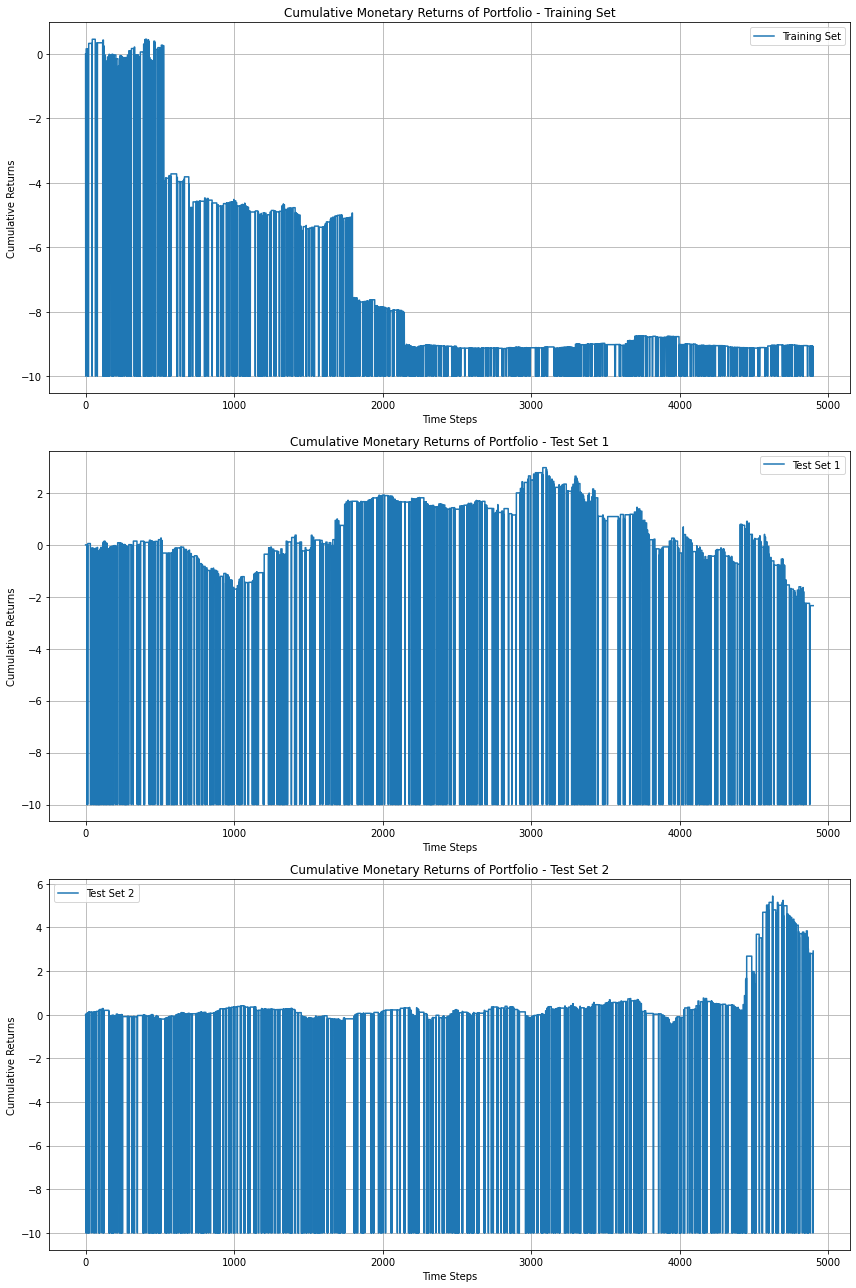

In [ ]:
import matplotlib.pyplot as plt

def plot_returns(train_returns, test1_returns, test2_returns):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    ax1.plot(train_returns, label="Training Set")
    ax1.set_xlabel("Time Steps")
    ax1.set_ylabel("Cumulative Returns")
    ax1.set_title("Cumulative Monetary Returns of Portfolio - Training Set")
    ax1.legend()
    ax1.grid()

    ax2.plot(test1_returns, label="Test Set 1")
    ax2.set_xlabel("Time Steps")
    ax2.set_ylabel("Cumulative Returns")
    ax2.set_title("Cumulative Monetary Returns of Portfolio - Test Set 1")
    ax2.legend()
    ax2.grid()

    ax3.plot(test2_returns, label="Test Set 2")
    ax3.set_xlabel("Time Steps")
    ax3.set_ylabel("Cumulative Returns")
    ax3.set_title("Cumulative Monetary Returns of Portfolio - Test Set 2")
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.show()

plot_returns(train_returns, test_returns_1, test_returns_2)